In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
folder_path = '/content/drive/MyDrive/Electricity-Power'
os.chdir(folder_path)


Mounted at /content/drive


In [2]:
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import gc
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from datetime import datetime


In [3]:
import re
def extract_first_part(s):
    # Find the first underscore followed by a digit
    match = re.search(r'_(?=\d)', s)
    if match:
        return s[:match.start()]
    else:
        return s

In [ ]:
path = 'delimiter/'
i=0
for full_name in os.listdir(path):
    name = full_name.split(".")[0]
    print(i+1 ,'- ', full_name)
    i+=1


1 -  Actual_generation_202301010000_202503050000_Quarterhour.csv
2 -  Forecasted_generation_Day-Ahead_202301010000_202503050000_Hour_Quarterhour.csv
3 -  Generation_Forecast_Intraday_202301010000_202503050000_Quarterhour.csv
4 -  Installed_generation_capacity_202301010000_202503050000_Year.csv
5 -  Actual_consumption_202301010000_202503050000_Quarterhour.csv
6 -  Forecasted_consumption_202301010000_202503050000_Quarterhour.csv
7 -  Day-ahead_prices_202301010000_202503050000_Hour.csv
8 -  Scheduled_commercial_exchanges_202301010000_202503050000_Quarterhour.csv
9 -  Cross-border_physical_flows_202301010000_202503050000_Quarterhour.csv
10 -  Balancing_energy_202301010000_202503050000_Quarterhour_Month.csv
11 -  Costs_of_TSOs__without_costs_of_DSOs__202301010000_202503050000_Month.csv
12 -  Frequency_Containment_Reserve_202301010000_202503050000_Quarterhour.csv
13 -  Automatic_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv
14 -  Manual_Frequency_Restoration_Reserve

In [ ]:
df = pd.read_csv('hourly_resampled_df_19052_196.csv')
df['End date'] = pd.to_datetime(df['End date'])

In [ ]:
df.columns

Index(['End date', 'Day-ahead_prices_Germany/Luxembourg [€/MWh]',
       'Day-ahead_prices_∅ DE/LU neighbours [€/MWh]',
       'Day-ahead_prices_Belgium [€/MWh]',
       'Day-ahead_prices_Denmark 1 [€/MWh]',
       'Day-ahead_prices_Denmark 2 [€/MWh]', 'Day-ahead_prices_France [€/MWh]',
       'Day-ahead_prices_Netherlands [€/MWh]',
       'Day-ahead_prices_Norway 2 [€/MWh]', 'Day-ahead_prices_Austria [€/MWh]',
       ...
       'price_rolling_7d_stdCzech Republic [€/MWh]',
       'price_lag_24hNorthern Italy [€/MWh]',
       'price_lag_168hNorthern Italy [€/MWh]',
       'price_rolling_7d_stdNorthern Italy [€/MWh]',
       'price_lag_24hSlovenia [€/MWh]', 'price_lag_168hSlovenia [€/MWh]',
       'price_rolling_7d_stdSlovenia [€/MWh]', 'price_lag_24hHungary [€/MWh]',
       'price_lag_168hHungary [€/MWh]', 'price_rolling_7d_stdHungary [€/MWh]'],
      dtype='object', length=197)

## 2. Correlation & Feature Relationships (10 Points)


#### What features have the strongest correlation with electricity prices?


In [ ]:
resampled_df = pd.read_csv('hourly_resampled_df_19052_196.csv')

In [ ]:
price_cols = [col for col in resampled_df.columns if 'day-ahead_prices' in col.lower()]
price_cols

['Day-ahead_prices_Germany/Luxembourg [€/MWh]',
 'Day-ahead_prices_∅ DE/LU neighbours [€/MWh]',
 'Day-ahead_prices_Belgium [€/MWh]',
 'Day-ahead_prices_Denmark 1 [€/MWh]',
 'Day-ahead_prices_Denmark 2 [€/MWh]',
 'Day-ahead_prices_France [€/MWh]',
 'Day-ahead_prices_Netherlands [€/MWh]',
 'Day-ahead_prices_Norway 2 [€/MWh]',
 'Day-ahead_prices_Austria [€/MWh]',
 'Day-ahead_prices_Poland [€/MWh]',
 'Day-ahead_prices_Sweden 4 [€/MWh]',
 'Day-ahead_prices_Switzerland [€/MWh]',
 'Day-ahead_prices_Czech Republic [€/MWh]',
 'Day-ahead_prices_Northern Italy [€/MWh]',
 'Day-ahead_prices_Slovenia [€/MWh]',
 'Day-ahead_prices_Hungary [€/MWh]']

In [ ]:
feature_cols = [col for col in resampled_df.columns if col not in price_cols]

# Compute full correlation matrix once (more efficient)
corr_matrix = resampled_df.corr(numeric_only=True)

# Filter features correlated with multiple price columns
correlated_features = []
for target in price_cols:
    # Get correlations for current target
    target_correlations = corr_matrix[target]

    # Filter features with |correlation| > 0.3 (excluding self-correlation)
    high_corr = target_correlations[
        (abs(target_correlations) > 0.5) &
        (target_correlations.index != target)
    ]

    correlated_features.append(high_corr.index.tolist())

# Find features common to multiple price columns
correlated_intersection_features = set.intersection(*map(set, correlated_features))
correlated_union_features = set.union(*map(set, correlated_features))
correlated_union_features


{'Actual_consumption_Hydro pumped storage [MWh]',
 'Actual_consumption_Residual load [MWh]',
 'Actual_generation_Biomass [MWh]',
 'Actual_generation_Fossil gas [MWh]',
 'Actual_generation_Hard coal [MWh]',
 'Actual_generation_Lignite [MWh]',
 'Actual_generation_Nuclear [MWh]',
 'Balancing_energy_Net income [€]',
 'Costs_of_TSOs__without_costs_of_DSOs__Network security of the TSOs [€]',
 'Cross-border_physical_flows_Luxembourg (export) [MWh]',
 'Cross-border_physical_flows_Norway (import) [MWh]',
 'Day-ahead_prices_Austria [€/MWh]',
 'Day-ahead_prices_Belgium [€/MWh]',
 'Day-ahead_prices_Czech Republic [€/MWh]',
 'Day-ahead_prices_Denmark 1 [€/MWh]',
 'Day-ahead_prices_Denmark 2 [€/MWh]',
 'Day-ahead_prices_France [€/MWh]',
 'Day-ahead_prices_Germany/Luxembourg [€/MWh]',
 'Day-ahead_prices_Hungary [€/MWh]',
 'Day-ahead_prices_Netherlands [€/MWh]',
 'Day-ahead_prices_Northern Italy [€/MWh]',
 'Day-ahead_prices_Norway 2 [€/MWh]',
 'Day-ahead_prices_Poland [€/MWh]',
 'Day-ahead_prices_Slov

In [ ]:
[col for col in correlated_union_features if col not in price_cols]

['price_lag_24hAustria [€/MWh]',
 'conventional Generation',
 'Actual_generation_Biomass [MWh]',
 'price_lag_24hNorway 2 [€/MWh]',
 'price_lag_168hSwitzerland [€/MWh]',
 'temp',
 'Actual_generation_Fossil gas [MWh]',
 'Actual_consumption_Residual load [MWh]',
 'Scheduled_commercial_exchanges_Luxembourg (export) [MWh]',
 'Actual_generation_Hard coal [MWh]',
 'price_lag_24hBelgium [€/MWh]',
 'Cross-border_physical_flows_Norway (import) [MWh]',
 'Actual_consumption_Hydro pumped storage [MWh]',
 'price_lag_24hSweden 4 [€/MWh]',
 'Manual_Frequency_Restoration_Reserve_Procurement price (-) [€/MW]',
 'Actual_generation_Lignite [MWh]',
 'price_lag_24hDenmark 2 [€/MWh]',
 'Actual_generation_Nuclear [MWh]',
 'renewable_ratio',
 'price_lag_24hFrance [€/MWh]',
 'Cross-border_physical_flows_Luxembourg (export) [MWh]',
 'Scheduled_commercial_exchanges_Norway (export) [MWh]',
 'Renewable Generation',
 'neighbor_price_avg',
 'residual_scheduled_commercial_exchanges_Luxembourg',
 'price_lag_24hSwitzerl

In [ ]:
correlated_intersection_features

{'conventional Generation', 'neighbor_price_avg'}

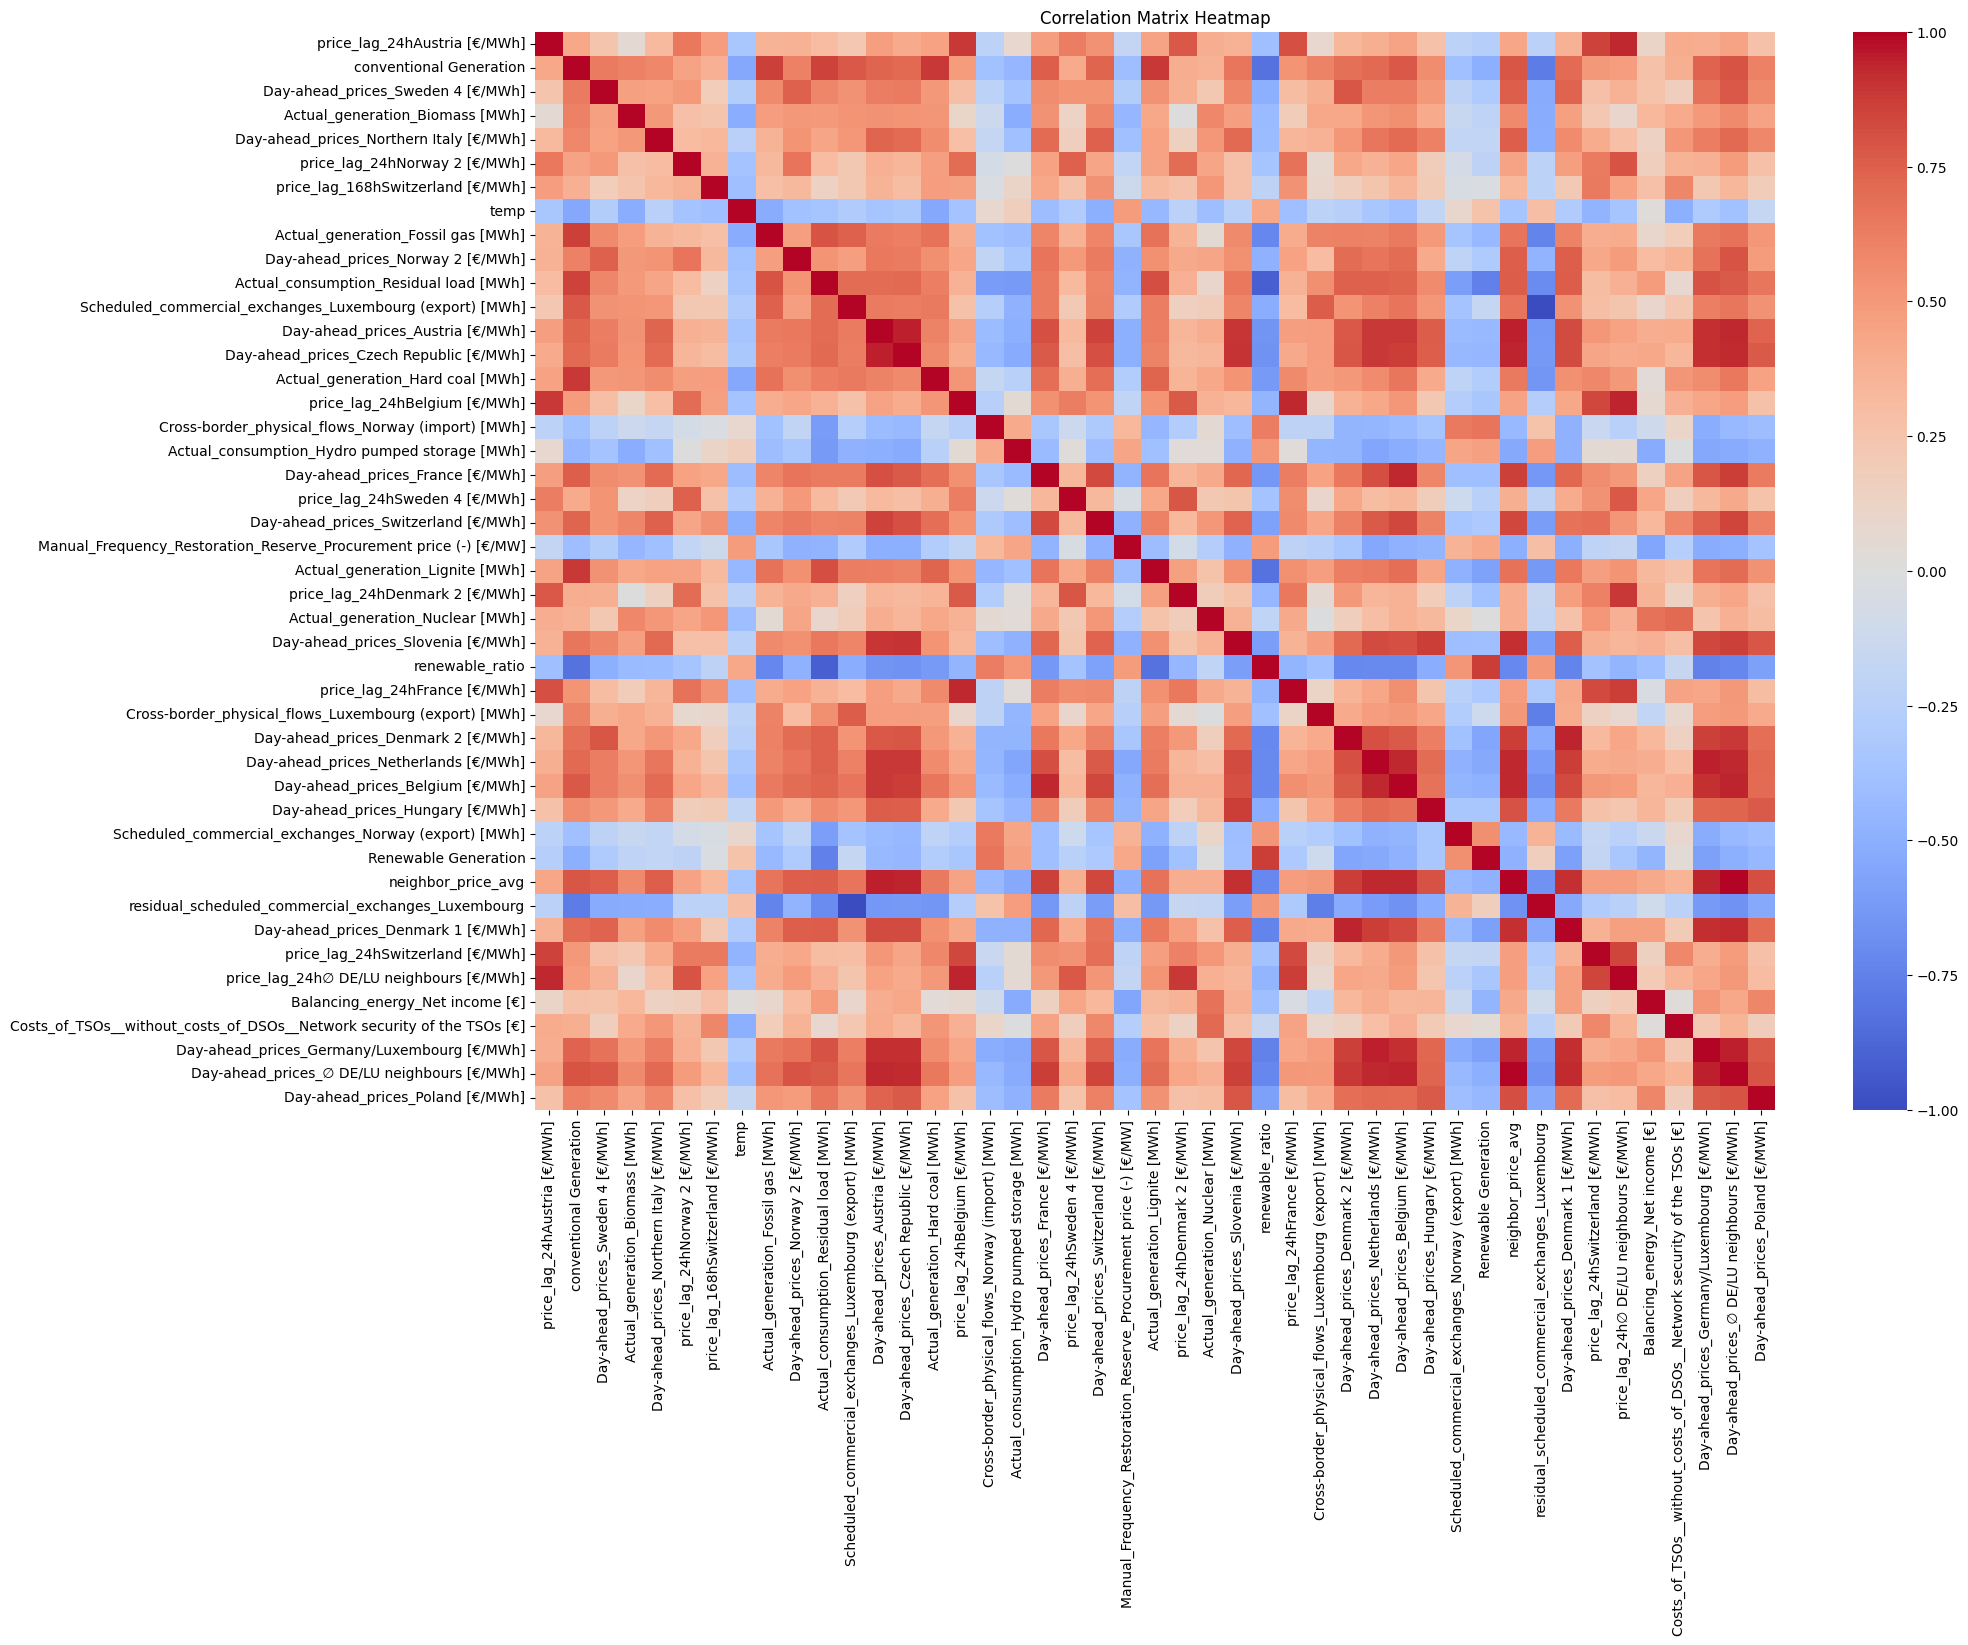

In [ ]:

corr_matrix = resampled_df[list(correlated_union_features)].corr()
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()


#### How do electricity prices correlate between different countries?


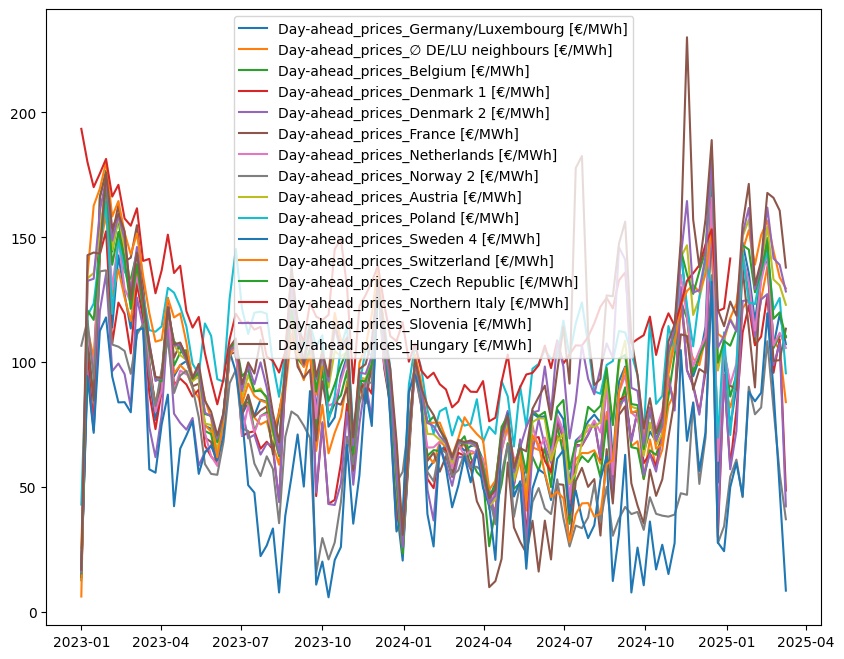

In [ ]:
plt.figure(figsize=(10, 8))
df.set_index('End date', inplace=True)
weekly_data = df.resample('W').mean()

for col in df.columns:
  if 'Day-ahead_prices' in col:
    plt.plot(weekly_data.index, weekly_data[col], label=col)
plt.legend()
plt.show()

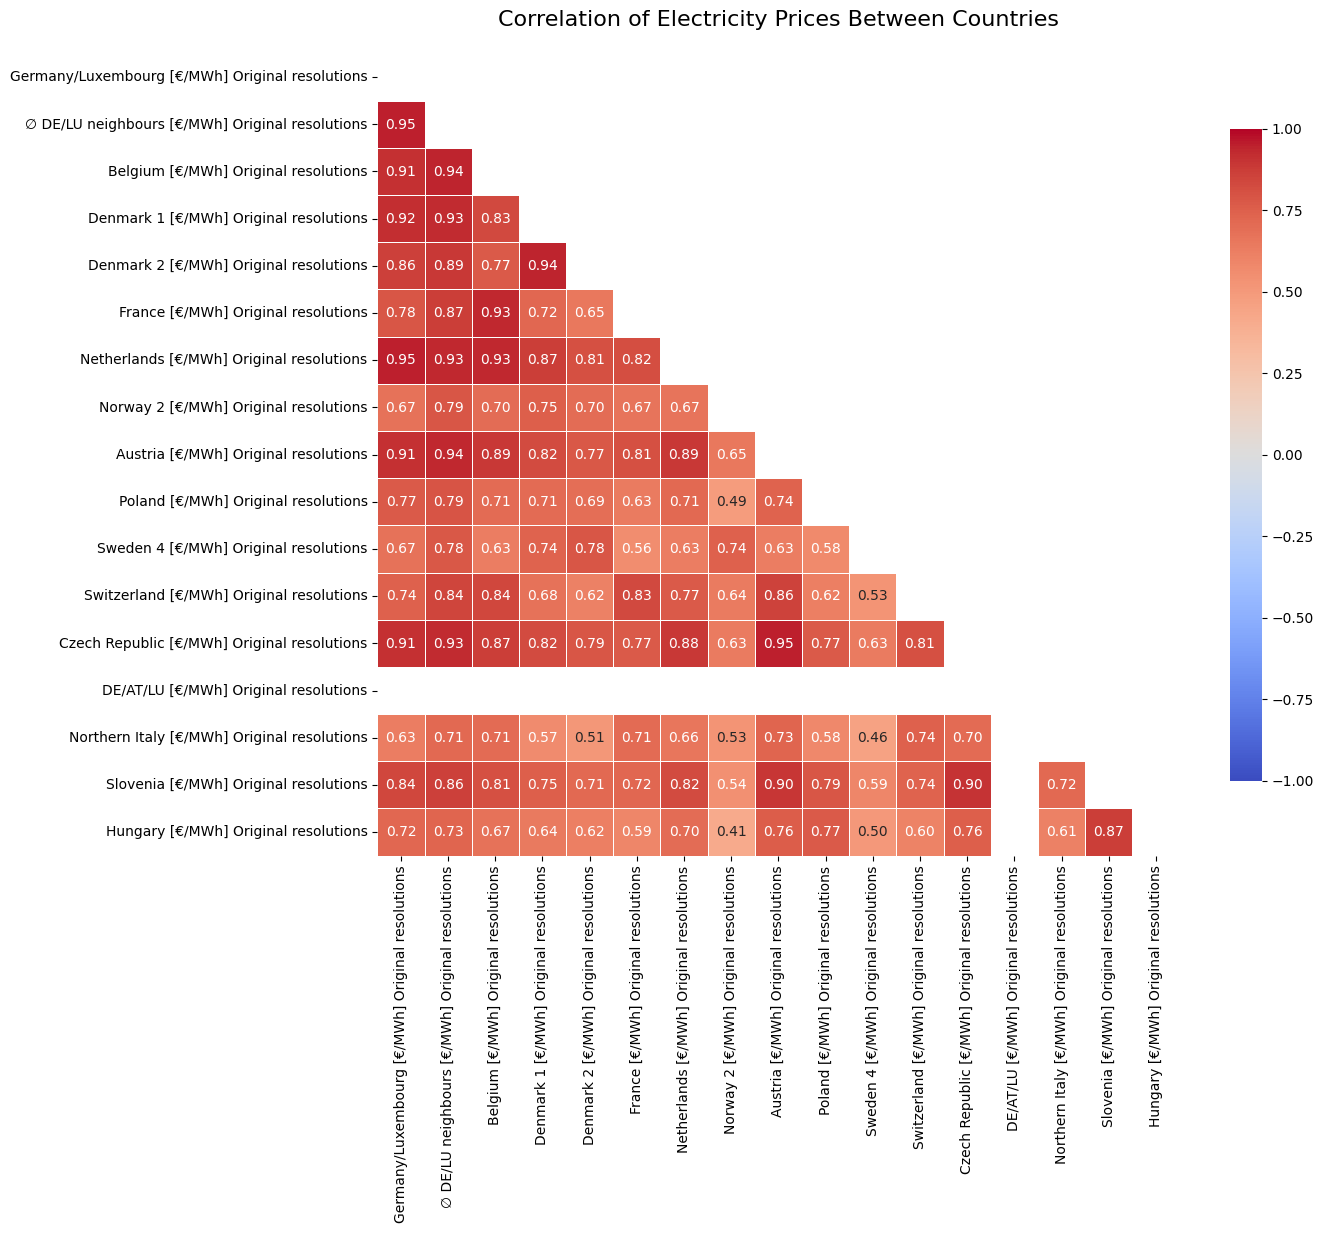

In [ ]:
df = pd.read_csv('delimiter/Day-ahead_prices_202301010000_202503050000_Hour.csv')
df = df.drop(columns=['End date', 'Start date'], )
correlation_matrix = df.corr()
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # For hiding redundant info

# Create the heatmap
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,  # Show correlation values
    fmt='.2f',   # Format with 2 decimal places
    cmap='coolwarm',  # Color scheme: blue for negative, red for positive correlations
    vmin=-1, vmax=1,  # Set the range of values
    center=0,    # Center the colormap at 0
    square=True, # Make cells square
    linewidths=.5,
    mask=mask,   # Apply mask to hide redundant info
    cbar_kws={"shrink": .8}
)

plt.title('Correlation of Electricity Prices Between Countries', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


<Figure size 1400x1200 with 0 Axes>

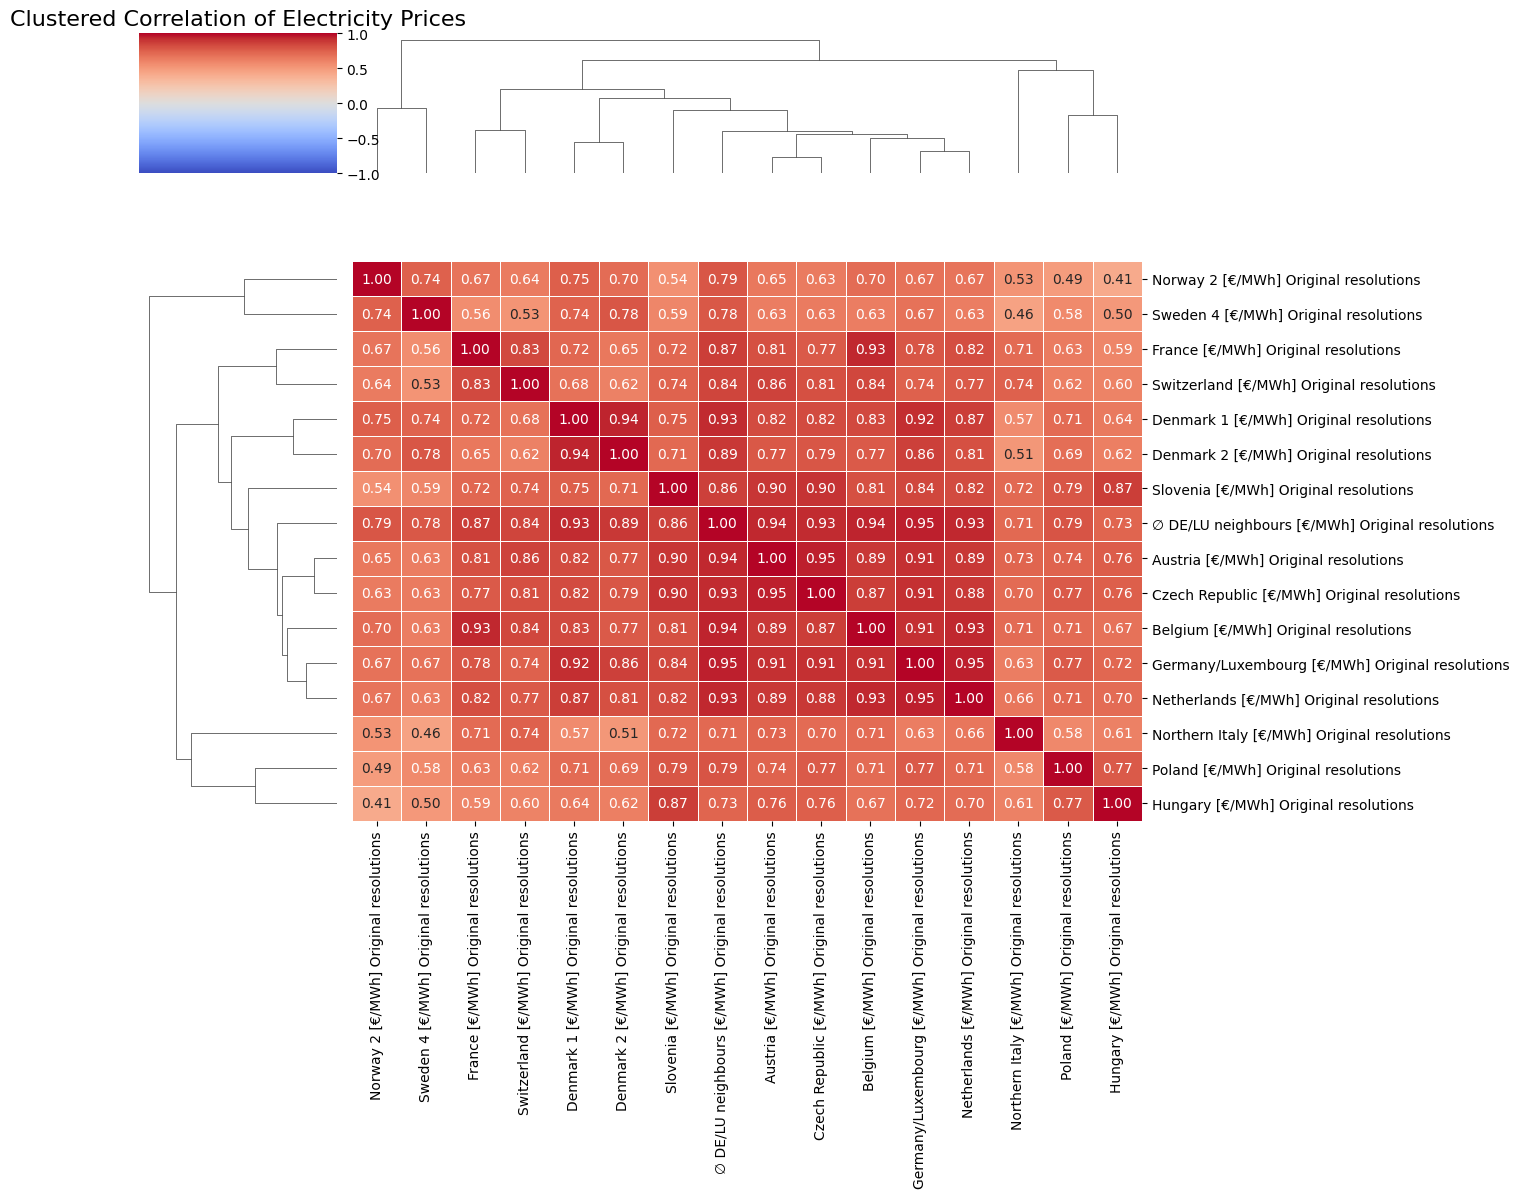

In [ ]:
df = pd.read_csv('delimiter/Day-ahead_prices_202301010000_202503050000_Hour.csv')
df = df.drop(columns=['End date', 'Start date'], )
df.dropna(axis='columns', how='all', inplace=True)
correlation_matrix = df.corr()
plt.figure(figsize=(14, 12))

# Create clustered heatmap
clustered_heatmap = sns.clustermap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    linewidths=.5,
    figsize=(14, 12),
    cbar_kws={"shrink": .8}
)

plt.title('Clustered Correlation of Electricity Prices', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Get the correlation matrix without redundant pairs
corr_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Stack the matrix and sort
corr_pairs = corr_matrix.stack().sort_values(ascending=False)

# Print top 10 most positively correlated pairs
print("\nTop 10 most positively correlated country pairs:")
print(corr_pairs.head(10))

# Print top 10 most negatively correlated pairs
print("\nTop 10 most negatively correlated country pairs:")
print(corr_pairs.tail(10))



Top 10 most positively correlated country pairs:
Austria [€/MWh] Original resolutions             Czech Republic [€/MWh] Original resolutions        0.951241
Germany/Luxembourg [€/MWh] Original resolutions  ∅ DE/LU neighbours [€/MWh] Original resolutions    0.947588
                                                 Netherlands [€/MWh] Original resolutions           0.946912
∅ DE/LU neighbours [€/MWh] Original resolutions  Belgium [€/MWh] Original resolutions               0.944453
Denmark 1 [€/MWh] Original resolutions           Denmark 2 [€/MWh] Original resolutions             0.941302
∅ DE/LU neighbours [€/MWh] Original resolutions  Austria [€/MWh] Original resolutions               0.935839
                                                 Netherlands [€/MWh] Original resolutions           0.934442
Belgium [€/MWh] Original resolutions             France [€/MWh] Original resolutions                0.934105
                                                 Netherlands [€/MWh] Original 

In [ ]:
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_ccf
def calculate_pairwise_ccf(data, countries, max_lags=10):
    """Calculate cross-correlations between all pairs of countries."""
    n_countries = len(countries)
    ccf_results = {}

    for i in range(n_countries):
        for j in range(i+1, n_countries):  # Only compute each pair once
            country1 = countries[i]
            country2 = countries[j]

            # Forward direction: country1 leading country2
            forward_ccf = ccf(data[country1], data[country2], nlags=max_lags)

            # Backward direction: country2 leading country1
            backward_ccf = ccf(data[country2], data[country1], nlags=max_lags)

            # Store results
            ccf_results[(country1, country2)] = {
                'forward': forward_ccf,  # country1 leading country2
                'backward': backward_ccf  # country2 leading country1
            }

    return ccf_results

# Calculate all pairwise cross-correlations
max_lags = 10
ccf_results = calculate_pairwise_ccf(df, df.columns, max_lags)
ccf_results

{('Germany/Luxembourg [€/MWh] Original resolutions',
  '∅ DE/LU neighbours [€/MWh] Original resolutions'): {'forward': array([0.94758754, 0.89192861, 0.77986817, 0.65922749, 0.55582698,
         0.48009612, 0.43500835, 0.42013166, 0.42940911, 0.45302902]),
  'backward': array([0.94758754, 0.89601437, 0.78495163, 0.66273331, 0.55605783,
         0.47533343, 0.4250999 , 0.40545031, 0.41124368, 0.43421082])},
 ('Germany/Luxembourg [€/MWh] Original resolutions',
  'Belgium [€/MWh] Original resolutions'): {'forward': array([0.91011436, 0.84523444, 0.73634527, 0.62487127, 0.53249115,
         0.46766022, 0.43366583, 0.42890192, 0.44552171, 0.4724663 ]),
  'backward': array([0.91011436, 0.88036616, 0.78697068, 0.67314688, 0.56745831,
         0.48227377, 0.42360341, 0.39420257, 0.39133168, 0.4093712 ])},
 ('Germany/Luxembourg [€/MWh] Original resolutions',
  'Denmark 1 [€/MWh] Original resolutions'): {'forward': array([0.9163228 , 0.8565958 , 0.74380387, 0.62642647, 0.52802074,
         0.457

In [71]:
1

1


#### What is the relationship between forecasted vs. actual electricity generation and consumption?



In [ ]:
# Set plotting styles for better visualization
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Create output directory for saving results
if not os.path.exists('output'):
    os.makedirs('output')
# Load datasets
actual_consumption = pd.read_csv('delimiter/Actual_consumption_202301010000_202503050000_Quarterhour.csv')
actual_generation = pd.read_csv('delimiter/Actual_generation_202301010000_202503050000_Quarterhour.csv')
forecast_gen_intraday = pd.read_csv('delimiter/Generation_Forecast_Intraday_202301010000_202503050000_Quarterhour.csv')
forecast_consumption = pd.read_csv('delimiter/Forecasted_consumption_202301010000_202503050000_Quarterhour.csv')
forecast_gen_day_ahead = pd.read_csv('delimiter/Forecasted_generation_Day-Ahead_202301010000_202503050000_Hour_Quarterhour.csv')

# Function to preprocess dataframes
def preprocess_dataframe(df):
    # Convert date columns to datetime
    df['Start date'] = pd.to_datetime(df['Start date'])
    df['End date'] = pd.to_datetime(df['End date'])

    # Set Start date as index
    df.set_index('Start date', inplace=True)

    # Drop End date column
    df.drop(columns=['End date'], inplace=True)

    # Add time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df.index.month % 12 // 3  # 0: Winter, 1: Spring, 2: Summer, 3: Fall

    return df

# Apply preprocessing to all dataframes
actual_consumption = preprocess_dataframe(actual_consumption)
actual_generation = preprocess_dataframe(actual_generation)
forecast_gen_intraday = preprocess_dataframe(forecast_gen_intraday)
forecast_consumption = preprocess_dataframe(forecast_consumption)
forecast_gen_day_ahead = preprocess_dataframe(forecast_gen_day_ahead)

# Create a new column for total actual generation
actual_generation['Total [MWh]'] = actual_generation.sum(axis=1)

# Add PV and Wind combined column to actual_generation for easier comparison
actual_generation['PV and Wind [MWh]'] = (
    actual_generation['Photovoltaics [MWh] Original resolutions'] +
    actual_generation['Wind onshore [MWh] Original resolutions'] +
    actual_generation['Wind offshore [MWh] Original resolutions']
)


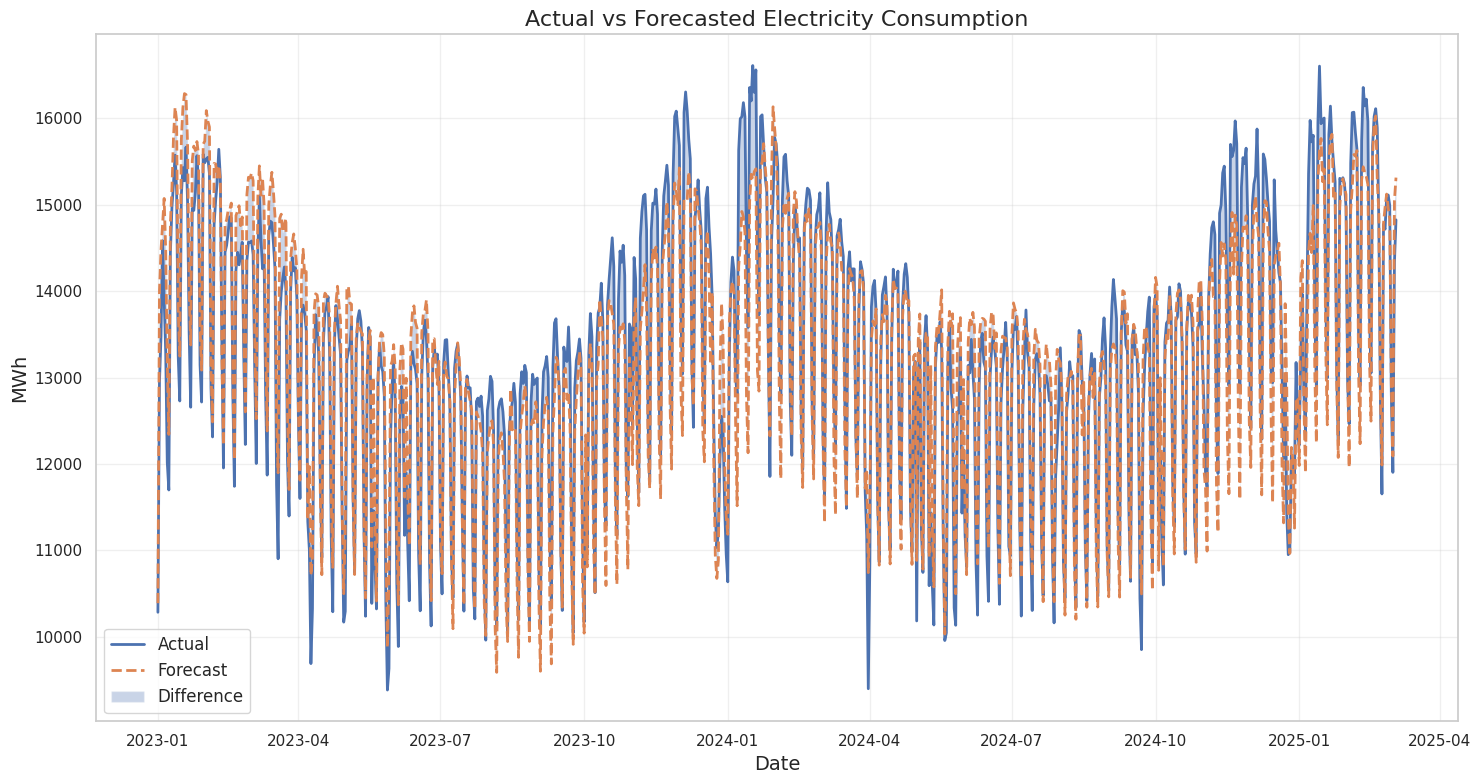

In [ ]:
def plot_timeseries_comparison(actual, forecast, column, title, start_date=None, end_date=None, freq='D'):
    """Plot time series comparison of actual vs forecast data for a specific column"""
    if start_date and end_date:
        actual = actual.loc[start_date:end_date]
        forecast = forecast.loc[start_date:end_date]

    # Resample data for better visualization
    actual_resampled = actual[column].resample(freq).mean()
    forecast_resampled = forecast[column].resample(freq).mean()

    # Create figure
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(actual_resampled.index, actual_resampled, label='Actual', linewidth=2)
    ax.plot(forecast_resampled.index, forecast_resampled, label='Forecast', linewidth=2, linestyle='--')
    ax.fill_between(actual_resampled.index, actual_resampled, forecast_resampled,
                    alpha=0.3, label='Difference')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('MWh', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    return fig

# Compare actual vs forecasted consumption
consumption_column = 'Total (grid load) [MWh] Original resolutions'
fig1 = plot_timeseries_comparison(
    actual_consumption, forecast_consumption,
    consumption_column,
    "Actual vs Forecasted Electricity Consumption"
)
# plt.savefig('output/consumption_comparison.png')
plt.close(fig1)


In [ ]:
def calculate_error_metrics(actual, forecast, column):
    """Calculate error metrics between actual and forecast data"""
    # Align data by index
    joined = pd.merge(actual[column], forecast[column],
                     left_index=True, right_index=True,
                     suffixes=('_actual', '_forecast'))

    # Drop rows with missing values
    joined = joined.dropna()

    # Calculate error metrics
    mae = mean_absolute_error(joined[f'{column}_actual'], joined[f'{column}_forecast'])
    rmse = np.sqrt(mean_squared_error(joined[f'{column}_actual'], joined[f'{column}_forecast']))
    mape = np.mean(np.abs((joined[f'{column}_actual'] - joined[f'{column}_forecast']) / joined[f'{column}_actual'])) * 100

    # Calculate correlation
    corr = joined.corr().iloc[0, 1]

    # Calculate bias (mean error)
    bias = np.mean(joined[f'{column}_forecast'] - joined[f'{column}_actual'])

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Correlation': corr,
        'Bias': bias
    }

# Calculate metrics for consumption forecast
consumption_metrics = calculate_error_metrics(
    actual_consumption, forecast_consumption,
    consumption_column
)
print("Consumption Forecast Error Metrics:")
for metric, value in consumption_metrics.items():
    print(f"{metric}: {value:.4f}")


Consumption Forecast Error Metrics:
MAE: 484.5229
RMSE: 613.0701
MAPE: 3.7051
Correlation: 0.9648
Bias: -39.6708


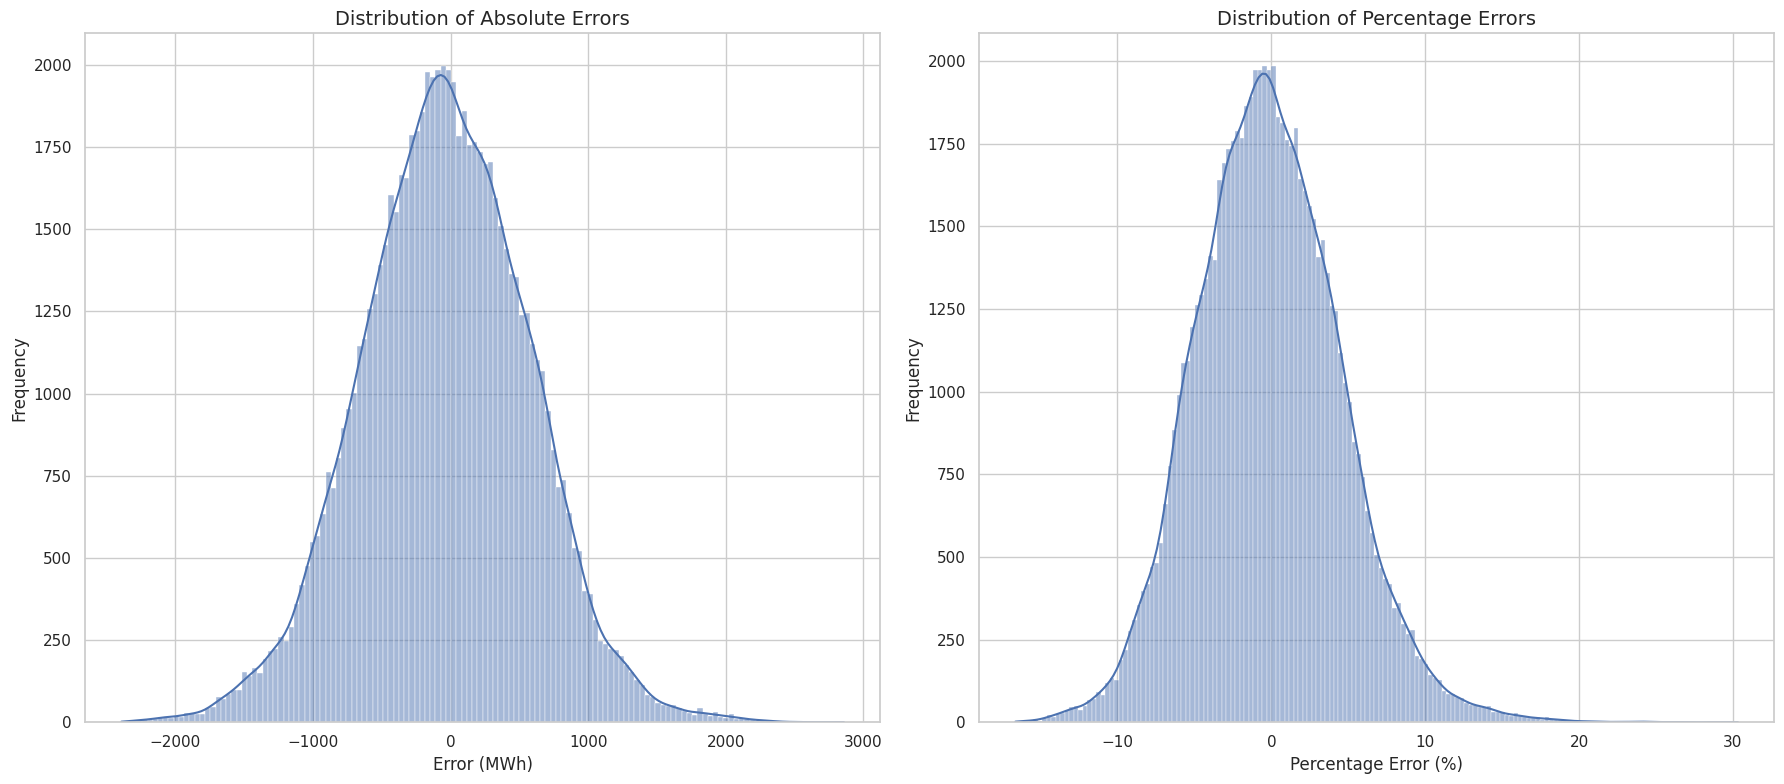

In [ ]:
def plot_error_distribution(actual, forecast, column):
    """Plot the distribution of errors between actual and forecast"""
    # Align data by index
    joined = pd.merge(actual[column], forecast[column],
                     left_index=True, right_index=True,
                     suffixes=('_actual', '_forecast'))

    # Calculate errors
    joined['error'] = joined[f'{column}_forecast'] - joined[f'{column}_actual']
    joined['percentage_error'] = (joined['error'] / joined[f'{column}_actual']) * 100
    joined['hour'] = joined.index.hour
    # Create subplot figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Plot error distribution
    sns.histplot(joined['error'], kde=True, ax=ax1)
    ax1.set_title('Distribution of Absolute Errors', fontsize=14)
    ax1.set_xlabel('Error (MWh)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)

    # Plot percentage error distribution
    sns.histplot(joined['percentage_error'], kde=True, ax=ax2)
    ax2.set_title('Distribution of Percentage Errors', fontsize=14)
    ax2.set_xlabel('Percentage Error (%)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)

    plt.tight_layout()
    plt.show()
    return fig, joined

# Plot error distribution for consumption
fig2, consumption_error_df = plot_error_distribution(
    actual_consumption, forecast_consumption,
    consumption_column
)
# plt.savefig('output/consumption_error_distribution.png')
plt.close(fig2)


In [ ]:
consumption_error_df[]

Total (grid load) [MWh] Original resolutions_actual  \
Start date                                                                 
2023-01-01 00:00:00                                            9673.00     
2023-01-01 00:15:00                                            9593.50     
2023-01-01 00:30:00                                            9562.00     
2023-01-01 00:45:00                                            9517.50     
2023-01-01 01:00:00                                            9433.25     
...                                                                ...     
2025-03-04 22:45:00                                                NaN     
2025-03-04 23:00:00                                                NaN     
2025-03-04 23:15:00                                                NaN     
2025-03-04 23:30:00                                                NaN     
2025-03-04 23:45:00                                                NaN     

                     Total (grid load) [MWh] Original resolutions_forecast  \
Start date                                                                   
2023-01-01 00:00:00                                           10652.25       
2023-01-01 00:15:00                                           10538.00       
2023-01-01 00:30:00                                           10380.00       
2023-01-01 00:45:00                                           10222.25       
2023-01-01 01:00:00                                           10107.75       
...                                                                ...       
2025-03-04 22:45:00                                           13647.00       
2025-03-04 23:00:00                                           13539.00       
2025-03-04 23:15:00                                           13374.25       
2025-03-04 23:30:00                                           13109.25       
2025-03-04 23:45:00                                           13022.50       

                      error  percentage_error  hour  
Start date                                           
2023-01-01 00:00:00  979.25         10.123540     0  
2023-01-01 00:15:00  944.50          9.845208     0  
2023-01-01 00:30:00  818.00          8.554696     0  
2023-01-01 00:45:00  704.75          7.404781     0  
2023-01-01 01:00:00  674.50          7.150240     1  
...                     ...               ...   ...  
2025-03-04 22:45:00     NaN               NaN    22  
2025-03-04 23:00:00     NaN               NaN    23  
2025-03-04 23:15:00     NaN               NaN    23  
2025-03-04 23:30:00     NaN               NaN    23  
2025-03-04 23:45:00     NaN               NaN    23  

[76240 rows x 5 columns]

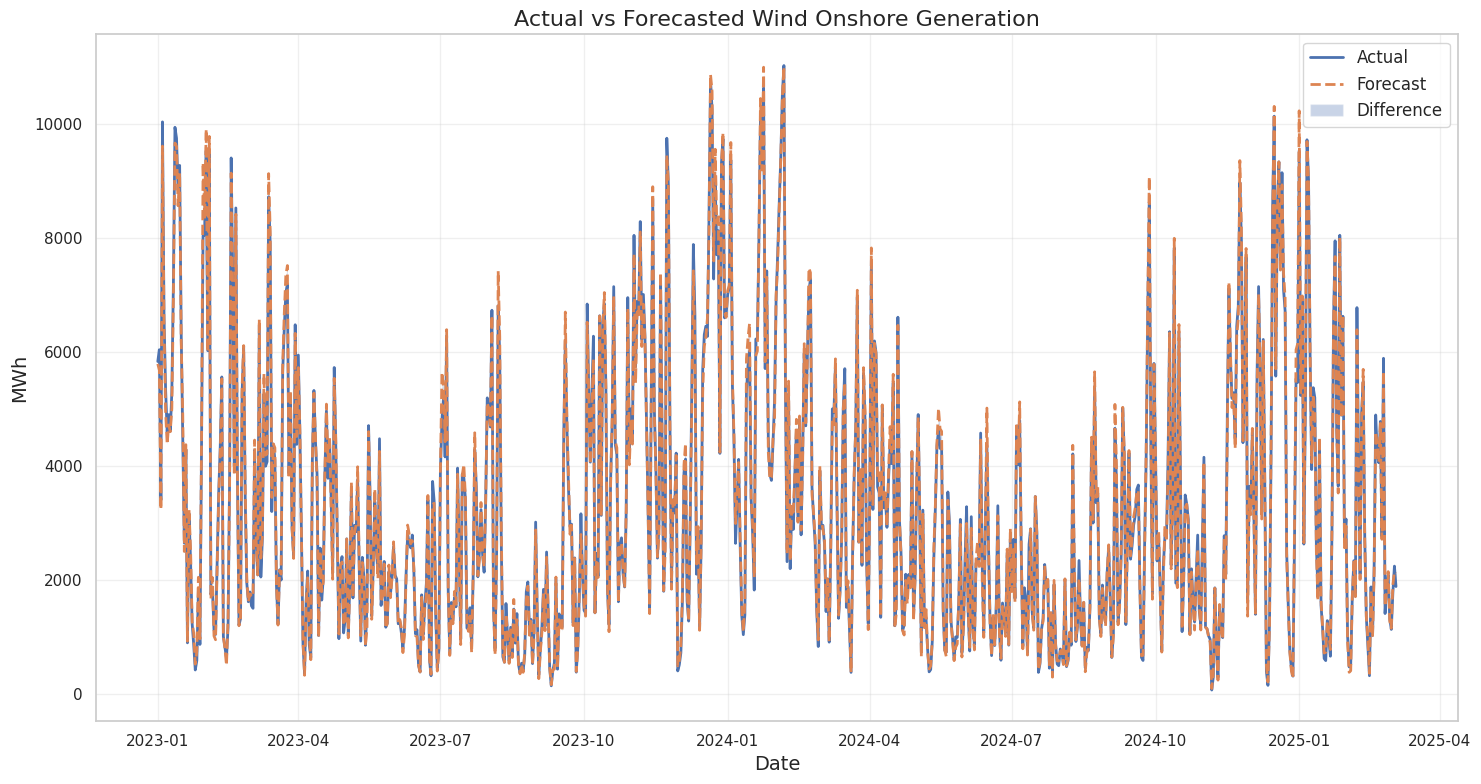

Wind Onshore Forecast Error Metrics:
MAE: 186.3880
RMSE: 286.3563
MAPE: 8.6901
Correlation: 0.9939
Bias: 9.2862


<Figure size 640x480 with 0 Axes>

In [ ]:
# Analyze Wind onshore first
wind_onshore_column = 'Wind onshore [MWh] Original resolutions'

fig4 = plot_timeseries_comparison(
    actual_generation, forecast_gen_intraday,
    wind_onshore_column,
    "Actual vs Forecasted Wind Onshore Generation"
)
plt.savefig('output/wind_onshore_comparison.png')
plt.close(fig4)

# Calculate metrics for wind onshore forecast
wind_metrics = calculate_error_metrics(
    actual_generation, forecast_gen_intraday,
    wind_onshore_column
)
print("Wind Onshore Forecast Error Metrics:")
for metric, value in wind_metrics.items():
    print(f"{metric}: {value:.4f}")

# Now


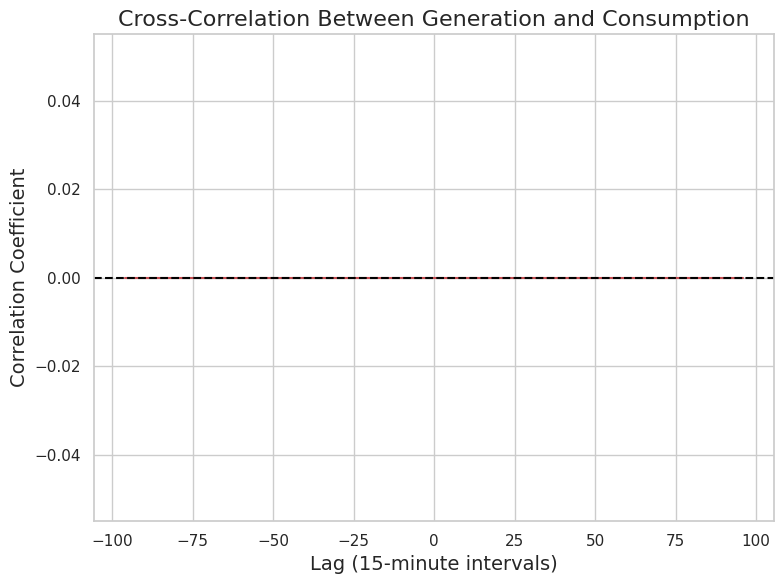

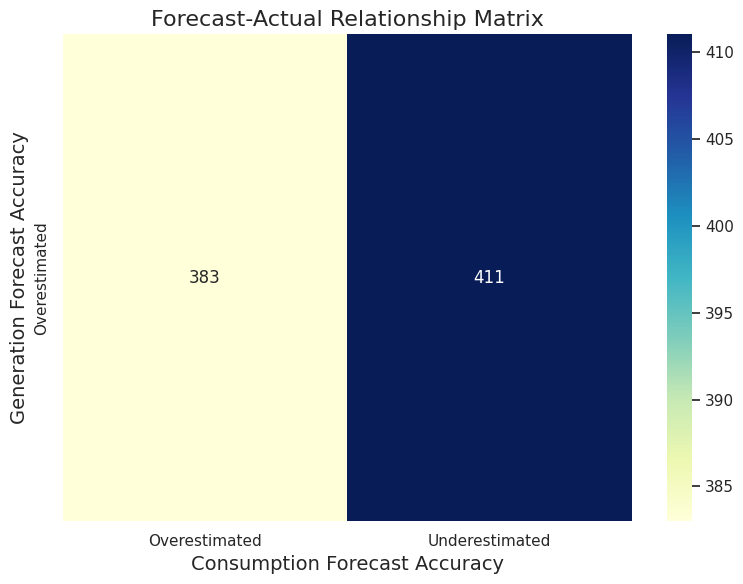

<Figure size 640x480 with 0 Axes>

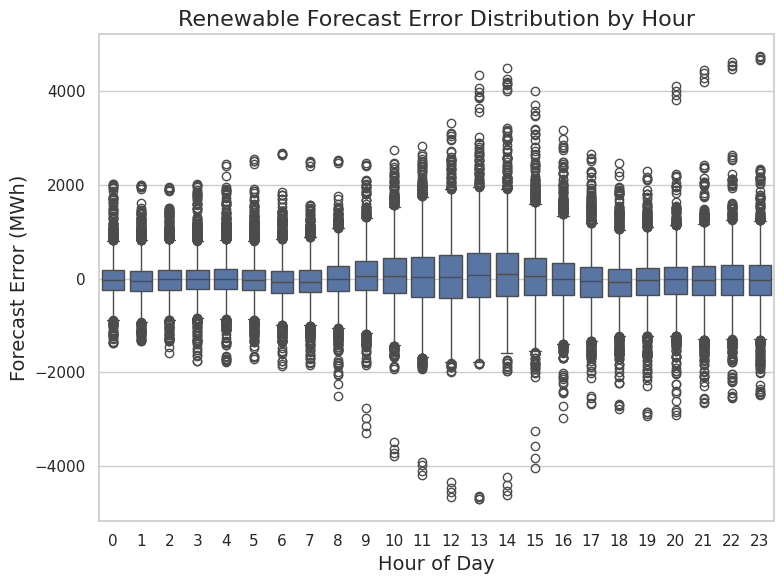

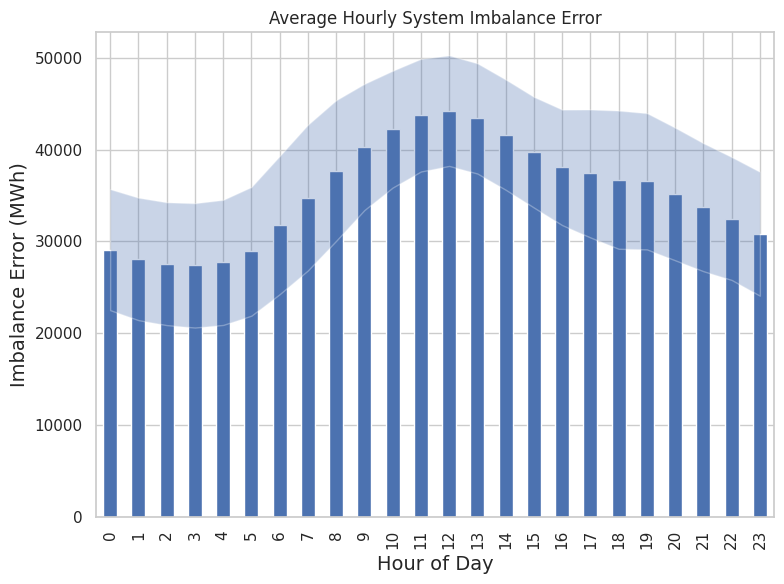

In [ ]:
## Section 1: Energy Balance Analysis

def calculate_energy_balance(actual_gen, actual_cons, forecast_gen, forecast_cons):
    """Calculate energy balance for both actual and forecast data"""
    # Actual energy balance
    actual_balance = pd.DataFrame({
        'Total Generation': actual_gen['Total [MWh]'],
        'Total Consumption': actual_cons['Total (grid load) [MWh] Original resolutions'],
        'Net Balance': actual_gen['Total [MWh]'] -
                      actual_cons['Total (grid load) [MWh] Original resolutions']
    })

    # Forecast energy balance (using day-ahead forecast)
    forecast_balance = pd.DataFrame({
        'Total Generation': forecast_gen_day_ahead['Total [MWh] Original resolutions'],
        'Total Consumption': forecast_cons['Total (grid load) [MWh] Original resolutions'],
        'Net Balance': forecast_gen_day_ahead['Total [MWh] Original resolutions'] -
                      forecast_cons['Total (grid load) [MWh] Original resolutions']
    })

    return actual_balance, forecast_balance

# Calculate energy balances
actual_balance, forecast_balance = calculate_energy_balance(
    actual_generation, actual_consumption,
    forecast_gen_day_ahead, forecast_consumption
)

## Section 2: Cross-Correlation Analysis

def cross_correlation_analysis(series1, series2, max_lag=24*4):
    """Calculate cross-correlation between two time series"""
    # Ensure aligned time indices
    aligned = pd.merge(series1, series2, left_index=True, right_index=True)

    # Calculate cross-correlation
    ccf = sm.tsa.stattools.ccf(aligned.iloc[:,0], aligned.iloc[:,1], adjusted=False)
    lags = np.arange(-max_lag, max_lag+1)

    # Plot results
    fig, ax = plt.subplots(figsize=(8,6))
    ax.stem(lags, ccf[len(ccf)//2 - max_lag : len(ccf)//2 + max_lag + 1])
    ax.set_title('Cross-Correlation Between Generation and Consumption', fontsize=16)
    ax.set_xlabel('Lag (15-minute intervals)', fontsize=14)
    ax.set_ylabel('Correlation Coefficient', fontsize=14)
    ax.axhline(0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()
    return fig

# Analyze cross-correlation between actual generation and consumption
fig4 = cross_correlation_analysis(
    actual_balance['Total Generation'],
    actual_balance['Total Consumption'],
    max_lag=96  # 24 hours in 15-min intervals
)
plt.close(fig4)

## Section 3: Temporal Decomposition Analysis

def decompose_timeseries(series, period=24*4*7):
    """Decompose time series into trend, seasonal, and residual components"""
    decomposition = seasonal_decompose(series, period=period, model='additive')

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 6))
    decomposition.observed.plot(ax=ax1, title='Observed')
    decomposition.trend.plot(ax=ax2, title='Trend')
    decomposition.seasonal.plot(ax=ax3, title='Seasonality')
    decomposition.resid.plot(ax=ax4, title='Residuals')
    plt.tight_layout()
    plt.show()

    return fig, decomposition

# Decompose actual net balance
# fig5, net_balance_decomp = decompose_timeseries(
#     actual_balance['Net Balance'].resample('H').mean(),
#     period=24*7  # Weekly seasonality
# )
# plt.close(fig5)

## Section 4: Forecast-Actual Relationship Matrix

def forecast_actual_relationship_matrix(actual, forecast):
    """Create a quadrant analysis of forecast vs actual relationships"""
    # Calculate daily aggregates
    daily_actual = actual.resample('D').mean()
    daily_forecast = forecast.resample('D').mean()

    # Create joint DataFrame
    joint_df = pd.merge(
        daily_actual, daily_forecast,
        left_index=True, right_index=True,
        suffixes=('_actual', '_forecast')
    )

    # Create quadrant analysis
    joint_df['gen_quadrant'] = np.where(
        joint_df['Total Generation_actual'] > joint_df['Total Generation_forecast'],
        'Underestimated', 'Overestimated'
    )
    joint_df['cons_quadrant'] = np.where(
        joint_df['Total Consumption_actual'] > joint_df['Total Consumption_forecast'],
        'Underestimated', 'Overestimated'
    )

    # Create relationship matrix
    matrix = joint_df.groupby(['gen_quadrant', 'cons_quadrant']).size().unstack().fillna(0)

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='.0f', cmap='YlGnBu', ax=ax)
    ax.set_title('Forecast-Actual Relationship Matrix', fontsize=16)
    ax.set_xlabel('Consumption Forecast Accuracy', fontsize=14)
    ax.set_ylabel('Generation Forecast Accuracy', fontsize=14)
    plt.tight_layout()
    plt.show()

    return fig

# Generate relationship matrix
fig6 = forecast_actual_relationship_matrix(actual_balance, forecast_balance)
plt.savefig('output/relationship_matrix.png')
plt.close(fig6)

## Section 5: Renewable Integration Analysis

def renewable_integration_analysis(actual_gen, forecast_gen):
    """Analyze renewable generation forecast accuracy"""
    # Combine renewable sources
    renewable_actual = actual_gen[[
        'Wind offshore [MWh] Original resolutions',
        'Wind onshore [MWh] Original resolutions',
        'Photovoltaics [MWh] Original resolutions'
    ]].sum(axis=1)

    renewable_forecast = forecast_gen[[
        'Wind offshore [MWh] Original resolutions',
        'Wind onshore [MWh] Original resolutions',
        'Photovoltaics [MWh] Original resolutions'
    ]].sum(axis=1)

    # Calculate error metrics
    error_df = pd.DataFrame({
        'Actual': renewable_actual,
        'Forecast': renewable_forecast,
        'Error': renewable_forecast - renewable_actual
    })

    # Plot error distribution by hour
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(x=error_df.index.hour, y='Error', data=error_df, ax=ax)
    ax.set_title('Renewable Forecast Error Distribution by Hour', fontsize=16)
    ax.set_xlabel('Hour of Day', fontsize=14)
    ax.set_ylabel('Forecast Error (MWh)', fontsize=14)
    plt.tight_layout()
    plt.show()

    return fig

# Analyze renewable integration
fig7 = renewable_integration_analysis(actual_generation, forecast_gen_day_ahead)
plt.close(fig7)

## Section 6: System Imbalance Analysis

def system_imbalance_analysis(actual_balance, forecast_balance):
    """Analyze system imbalance patterns"""
    # Combine actual and forecast balances
    imbalance = pd.DataFrame({
        'Actual Net Balance': actual_balance['Net Balance'],
        'Forecast Net Balance': forecast_balance['Net Balance'],
        'Imbalance Error': forecast_balance['Net Balance'] - actual_balance['Net Balance']
    })

    # Calculate hourly statistics
    hourly_stats = imbalance.groupby(imbalance.index.hour).agg({
        'Imbalance Error': ['mean', 'std', 'min', 'max']
    })

    # Plot hourly imbalance patterns
    fig, ax = plt.subplots(figsize=(8, 6))
    hourly_stats['Imbalance Error']['mean'].plot(
        kind='bar',
        title='Average Hourly System Imbalance Error',
        ax=ax
    )
    ax.fill_between(
        hourly_stats.index,
        hourly_stats['Imbalance Error']['mean'] - hourly_stats['Imbalance Error']['std'],
        hourly_stats['Imbalance Error']['mean'] + hourly_stats['Imbalance Error']['std'],
        alpha=0.3
    )
    ax.set_xlabel('Hour of Day', fontsize=14)
    ax.set_ylabel('Imbalance Error (MWh)', fontsize=14)
    plt.tight_layout()
    plt.show()

    return fig

# Analyze system imbalance
fig8 = system_imbalance_analysis(actual_balance, forecast_balance)
plt.close(fig8)


In [ ]:
actual_consumption = pd.read_csv('delimiter/Actual_consumption_202301010000_202503050000_Quarterhour.csv')
actual_generation = pd.read_csv('delimiter/Actual_generation_202301010000_202503050000_Quarterhour.csv')
forecast_gen_intraday = pd.read_csv('delimiter/Generation_Forecast_Intraday_202301010000_202503050000_Quarterhour.csv')
forecast_consumption = pd.read_csv('delimiter/Forecasted_consumption_202301010000_202503050000_Quarterhour.csv')
forecast_gen_day_ahead = pd.read_csv('delimiter/Forecasted_generation_Day-Ahead_202301010000_202503050000_Hour_Quarterhour.csv')
actual_consumption['End date'] = pd.to_datetime(actual_consumption['End date'])
actual_generation['End date'] = pd.to_datetime(actual_generation['End date'])
actual_consumption.set_index('End date', inplace=True)
actual_generation.set_index('End date', inplace=True)
actual_consumption.drop('Start date', axis=1, inplace=True)
actual_generation.drop('Start date', axis=1, inplace=True)

cols = ['Wind offshore [MWh] Original resolutions',
       'Wind onshore [MWh] Original resolutions',
       'Photovoltaics [MWh] Original resolutions',]
renewable= ['Biomass [MWh] Original resolutions',
  'Hydropower [MWh] Original resolutions',
  'Wind offshore [MWh] Original resolutions',
  'Wind onshore [MWh] Original resolutions',
  'Photovoltaics [MWh] Original resolutions',
  'Other renewable [MWh] Original resolutions',]
conventional =['Nuclear [MWh] Original resolutions',
  'Lignite [MWh] Original resolutions',
  'Hard coal [MWh] Original resolutions',
  'Fossil gas [MWh] Original resolutions',
  'Hydro pumped storage [MWh] Original resolutions',
  'Other conventional [MWh] Original resolutions']

actual_generation['Photovoltaics and wind [MWh] Original resolutions'] = actual_generation[cols].sum(axis =1)
actual_generation['renewable'] = actual_generation[renewable].sum(axis =1)
actual_generation['conventional'] = actual_generation[conventional].sum(axis =1)
actual_generation['Total Generation'] = actual_generation['conventional'] +actual_generation['renewable']


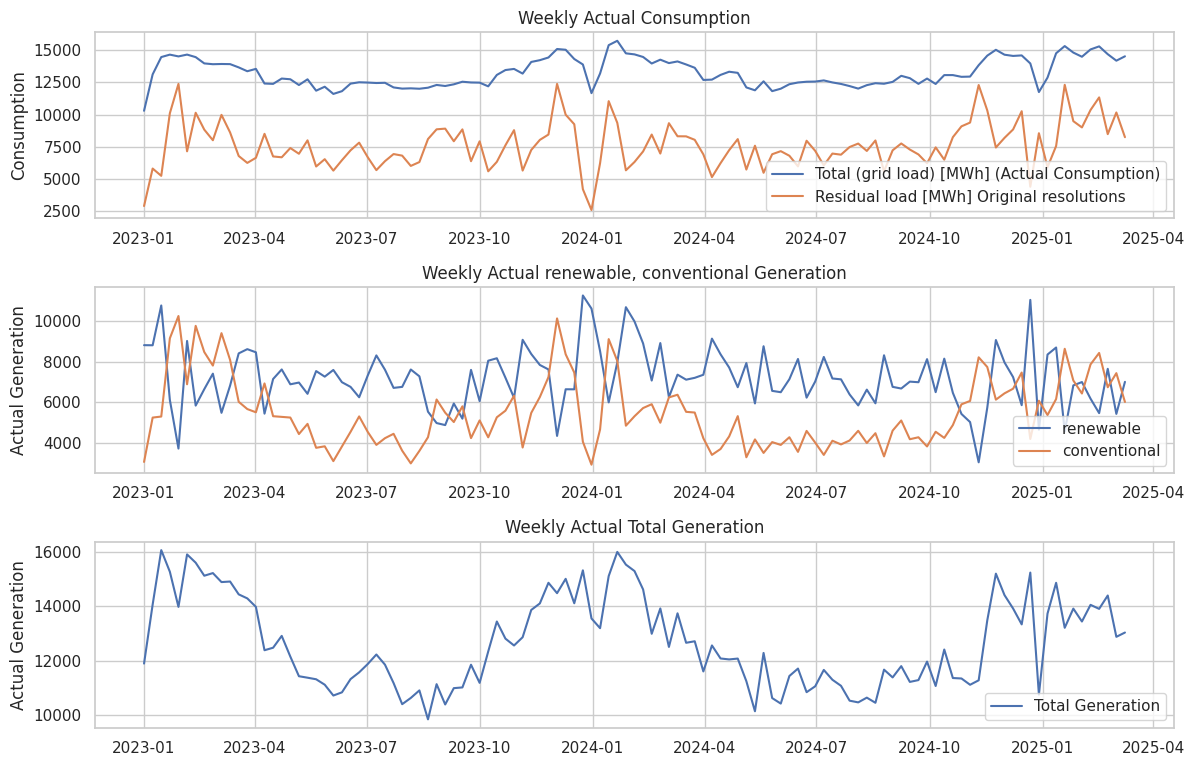

In [ ]:


fig, axs = plt.subplots(3, figsize=(12, 8))
hourly_data = actual_consumption.resample('W').mean()
axs[0].plot(hourly_data.index, hourly_data['Total (grid load) [MWh] Original resolutions'], label ='Total (grid load) [MWh] (Actual Consumption)')
axs[0].plot(hourly_data.index, hourly_data[ 'Residual load [MWh] Original resolutions'], label = 'Residual load [MWh] Original resolutions')
axs[0].set_title('Weekly Actual Consumption')
axs[0].set_ylabel('Consumption')
axs[0].legend()

# actual generation
cols = ['renewable', 'conventional',
        # 'Total Generation'
        ]
for col in cols:
  hourly_data = actual_generation.resample('W').mean()
  axs[1].plot(hourly_data.index, hourly_data[col], label =col)
  axs[1].set_ylabel('Actual Generation')
  axs[1].set_title('Weekly Actual renewable, conventional Generation')
  axs[1].legend(loc='lower right')

# actual generation
cols = [
        'Total Generation'
        ]
for col in cols:
  hourly_data = actual_generation.resample('W').mean()
  axs[2].plot(hourly_data.index, hourly_data[col], label =col)
  axs[2].set_ylabel('Actual Generation')
  axs[2].set_title('Weekly Actual Total Generation')
  axs[2].legend(loc='lower right')

for ax in axs:
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

fig.suptitle('', fontsize=16 , )
plt.tight_layout()
plt.show()

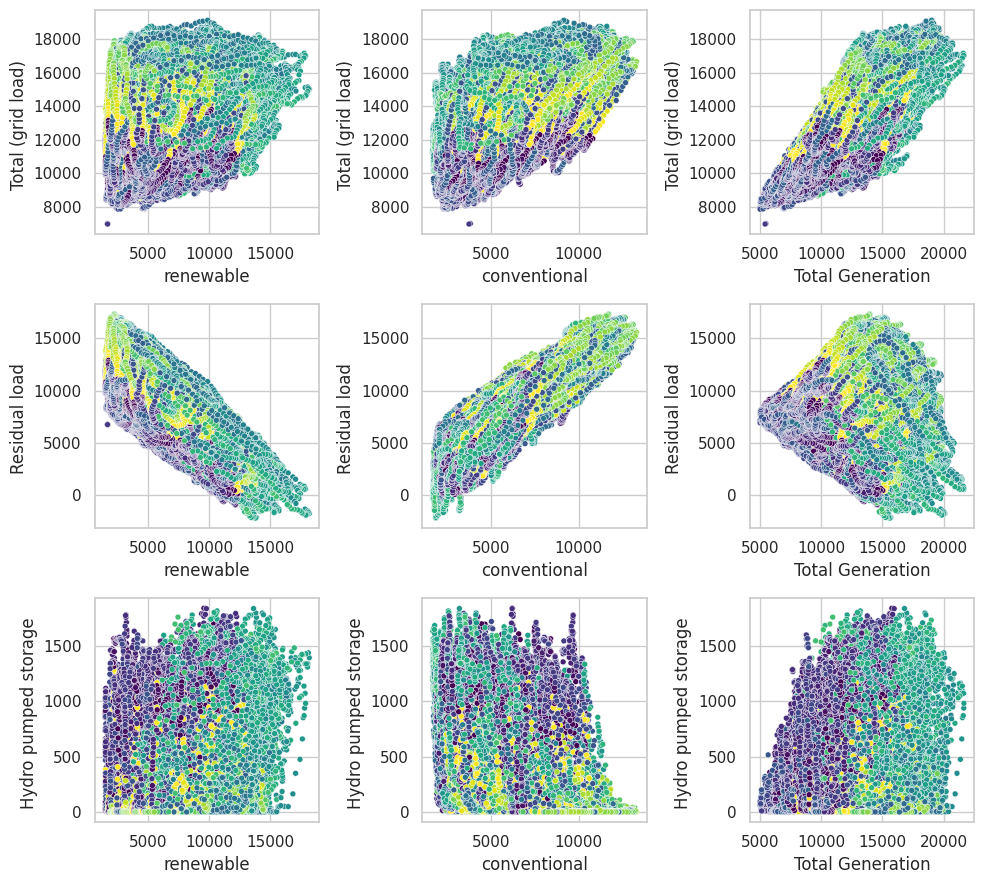

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 9))
c = 0
consumption_features = ['Total (grid load) [MWh] Original resolutions',
                       'Residual load [MWh] Original resolutions',
                        'Hydro pumped storage [MWh] Original resolutions']
generation_features = [

                       'renewable',
                       'conventional',
                      'Total Generation', ]

for i in consumption_features:
    for j in generation_features:
        row = c // 3  # Integer division for row index
        col = c % 3   # Remainder for column index
        ax = axes[row][col]

        sns.scatterplot(
            x=actual_generation[j],
            y=actual_consumption[i],
            hue=actual_generation['hour'],
            palette='viridis',
            size=1,
            legend=False,
            ax=ax
        )
        ax.set(xlabel=j.split('[')[0], ylabel=i.split('[')[0])
        c += 1

plt.tight_layout()
plt.show()


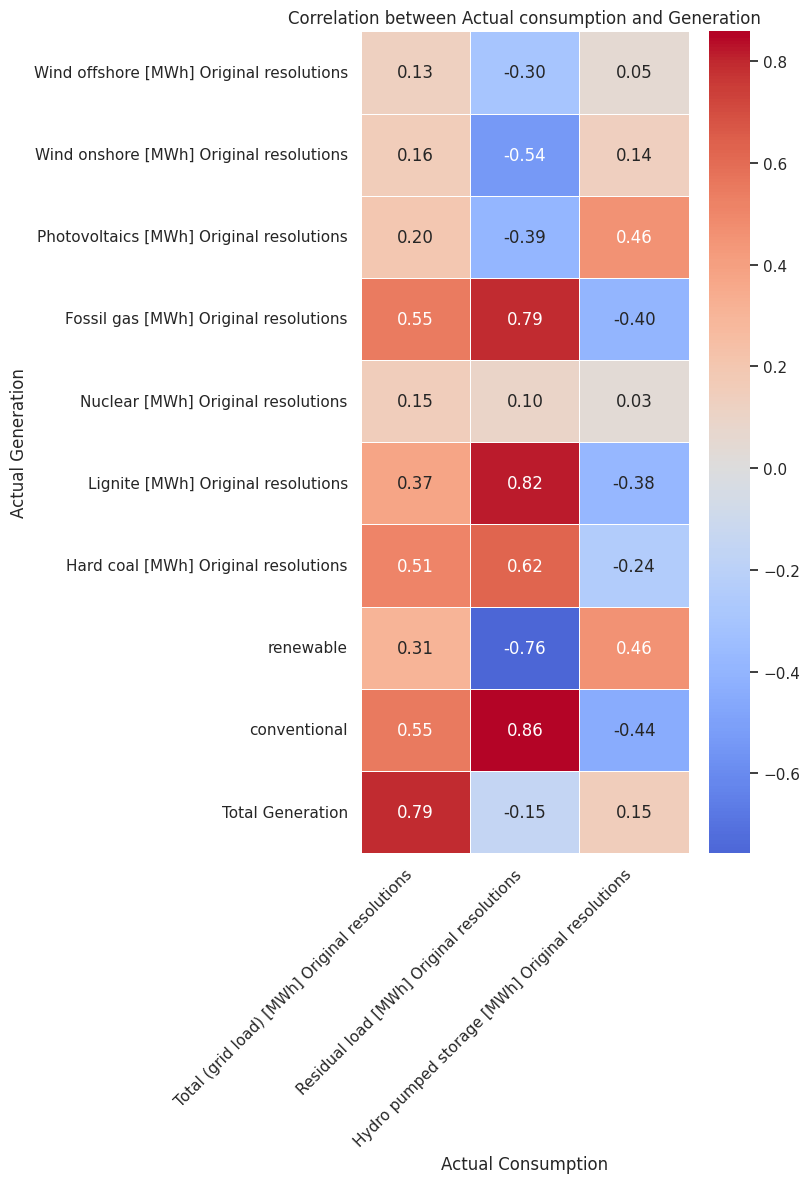

In [ ]:
consumption_features = ['Total (grid load) [MWh] Original resolutions',
                       'Residual load [MWh] Original resolutions',
                        'Hydro pumped storage [MWh] Original resolutions']
generation_features = ['Wind offshore [MWh] Original resolutions',
                      'Wind onshore [MWh] Original resolutions',
                      'Photovoltaics [MWh] Original resolutions',
                      'Fossil gas [MWh] Original resolutions',
                        'Nuclear [MWh] Original resolutions',
                        'Lignite [MWh] Original resolutions',
                        'Hard coal [MWh] Original resolutions',
                       'renewable', 'conventional',
                      'Total Generation', ]
corr_matrix = actual_consumption[consumption_features].apply(
    lambda col: actual_generation[generation_features].corrwith(col)
)
plt.figure(figsize=(8, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    linewidths=0.5
)
plt.title('Correlation between Actual consumption and Generation')
plt.xlabel('Actual Consumption')
plt.ylabel('Actual Generation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### How do balancing reserves and TSO costs impact electricity prices?

10 -  Balancing_energy_202301010000_202503050000_Quarterhour_Month.csv

11 -  Costs_of_TSOs__without_costs_of_DSOs__202301010000_202503050000_Month.csv

12 -  Frequency_Containment_Reserve_202301010000_202503050000_Quarterhour.csv

13- Automatic_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv

14 - Manual_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv

15 -  Exported_balancing_services_202301010000_202503050000_Quarterhour.csv

16 -  Imported_balancing_services_202301010000_202503050000_Quarterhour.csv

In [29]:
dic = {'Balancing_energy' : pd.read_csv('delimiter/Balancing_energy_202301010000_202503050000_Quarterhour_Month.csv'),
'Frequency_Containment_Reserve' : pd.read_csv('delimiter/Frequency_Containment_Reserve_202301010000_202503050000_Quarterhour.csv'),
'Automatic_Frequency_Restoration_Reserve' : pd.read_csv('delimiter/Automatic_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv'),
'Manual_Frequency_Restoration_Reserve' : pd.read_csv('delimiter/Manual_Frequency_Restoration_Reserve_202301010000_202503050000_Quarterhour.csv'),
'Exported_balancing_services' : pd.read_csv('delimiter/Exported_balancing_services_202301010000_202503050000_Quarterhour.csv'),
'Imported_balancing_services' : pd.read_csv('delimiter/Imported_balancing_services_202301010000_202503050000_Quarterhour.csv'),
'cost_tso' : pd.read_csv('delimiter/Costs_of_TSOs__without_costs_of_DSOs__202301010000_202503050000_Month.csv'),
'prices' : pd.read_csv('delimiter/Day-ahead_prices_202301010000_202503050000_Hour.csv'),}
for name, df in dic.items():
  df.set_index('End date', inplace=True)
  df.index = pd.to_datetime(df.index )
  df.drop(columns=['Start date'],inplace=True)
  if name == 'prices':
    df['Total Price'] = df.sum(axis = 1)

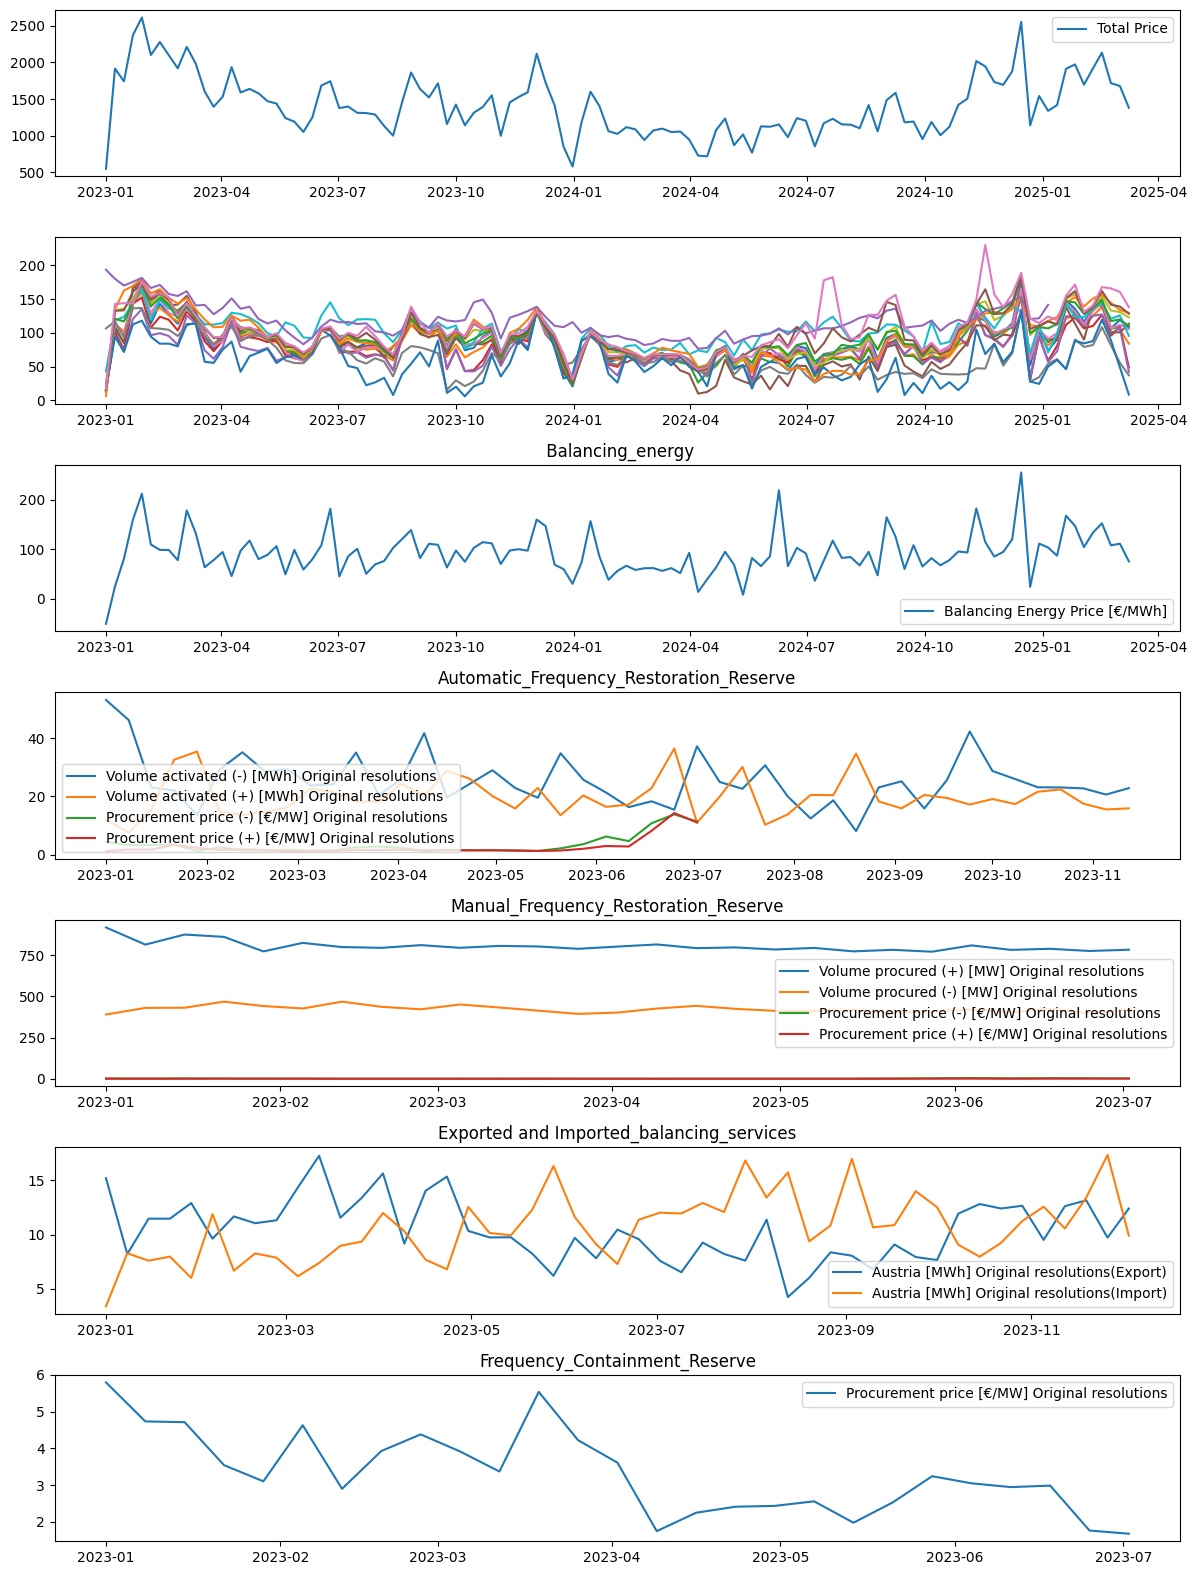

In [39]:
fig, axs = plt.subplots(7,1, figsize=(12, 16))
prices_weekly = dic['prices'].resample('W').mean()
axs[0].plot(prices_weekly.index, prices_weekly['Total Price'], label = 'Total Price')
axs[0].legend()

for col in prices_weekly.columns:
  if col != 'Total Price':
    axs[1].plot(prices_weekly.index, prices_weekly[col], label = col.split('[')[0])
# axs[1].legend()

Balancing_energy_weekly = dic['Balancing_energy'].resample('W').mean()
axs[2].plot(Balancing_energy_weekly.index, Balancing_energy_weekly['Price [€/MWh] Original resolutions'], label ='Balancing Energy Price [€/MWh]')
axs[2].set_title(' Balancing_energy')
axs[2].legend()

AFRR_weekly = dic['Automatic_Frequency_Restoration_Reserve'].resample('W').mean()
axs[3].plot(AFRR_weekly.index, AFRR_weekly['Volume activated (-) [MWh] Original resolutions'], label ='Volume activated (-) [MWh] Original resolutions')
axs[3].plot(AFRR_weekly.index, AFRR_weekly['Volume activated (+) [MWh] Original resolutions'], label ='Volume activated (+) [MWh] Original resolutions')
axs[3].plot(AFRR_weekly.index, AFRR_weekly['Procurement price (-) [€/MW] Original resolutions'], label ='Procurement price (-) [€/MW] Original resolutions')
axs[3].plot(AFRR_weekly.index, AFRR_weekly['Procurement price (+) [€/MW] Original resolutions'], label ='Procurement price (+) [€/MW] Original resolutions')
axs[3].set_title('Automatic_Frequency_Restoration_Reserve')
axs[3].legend(loc='lower left')

MFRR_weekly = dic['Manual_Frequency_Restoration_Reserve'].resample('W').mean()
axs[4].plot(MFRR_weekly.index, MFRR_weekly['Volume procured (+) [MW] Original resolutions'], label ='Volume procured (+) [MW] Original resolutions')
axs[4].plot(MFRR_weekly.index, MFRR_weekly['Volume procured (-) [MW] Original resolutions'], label ='Volume procured (-) [MW] Original resolutions')
axs[4].plot(MFRR_weekly.index, MFRR_weekly['Procurement price (-) [€/MW] Original resolutions'], label ='Procurement price (-) [€/MW] Original resolutions')
axs[4].plot(MFRR_weekly.index, MFRR_weekly['Procurement price (+) [€/MW] Original resolutions'], label ='Procurement price (+) [€/MW] Original resolutions')
axs[4].set_title('Manual_Frequency_Restoration_Reserve')
axs[4].legend()

Exported_balancing_services = dic['Exported_balancing_services'].resample('W').mean()
Imported_balancing_services = dic['Imported_balancing_services'].resample('W').mean()
axs[5].plot(Exported_balancing_services.index, Exported_balancing_services['Austria [MWh] Original resolutions'], label ='Austria [MWh] Original resolutions(Export)')
axs[5].plot(Imported_balancing_services.index, Imported_balancing_services['Austria [MWh] Original resolutions'], label ='Austria [MWh] Original resolutions(Import)')
axs[5].set_title('Exported and Imported_balancing_services')
axs[5].legend()


FCR_weekly = dic['Frequency_Containment_Reserve'].resample('W').mean()
axs[6].plot(FCR_weekly.index, FCR_weekly['Procurement price [€/MW] Original resolutions'], label ='Procurement price [€/MW] Original resolutions')
axs[6].set_title('Frequency_Containment_Reserve')
axs[6].legend()

for ax in axs:
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

fig.suptitle('', fontsize=16 , )
plt.tight_layout()
plt.show()

In [45]:
resampled_df = pd.read_csv('hourly_resampled_df_19052_196.csv')
resampled_df.set_index('End date', inplace=True)
resampled_df.index = pd.to_datetime(resampled_df.index )
[col for col in resampled_df.columns if 'tso' in col.lower()]

['Costs_of_TSOs__without_costs_of_DSOs__Balancing services [€]',
 'Costs_of_TSOs__without_costs_of_DSOs__Network security of the TSOs [€]',
 'Costs_of_TSOs__without_costs_of_DSOs__Countertrading [€]']

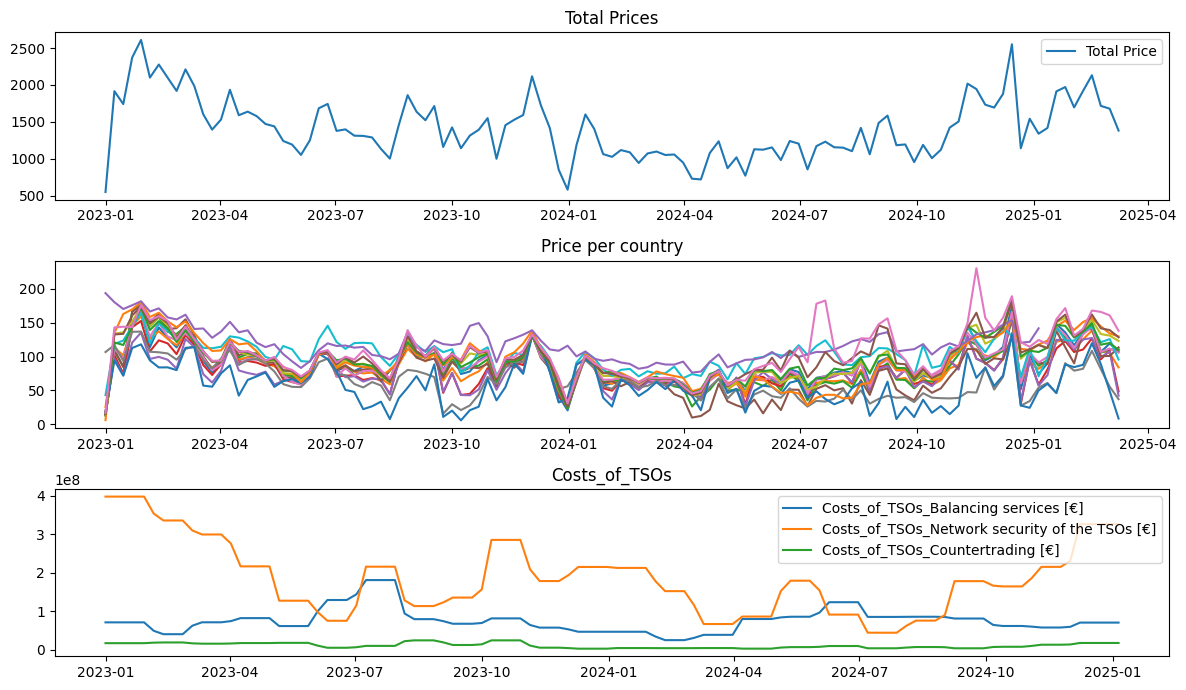

In [54]:
fig, axs = plt.subplots(3,1, figsize=(12, 7))
prices_weekly = dic['prices'].resample('W').mean()
axs[0].plot(prices_weekly.index, prices_weekly['Total Price'], label = 'Total Price')
axs[0].legend()
axs[0].set_title('Total Prices')

for col in prices_weekly.columns:
  if col != 'Total Price':
    axs[1].plot(prices_weekly.index, prices_weekly[col], label = col.split('[')[0])
# axs[1].legend()
axs[1].set_title('Price per country')

Costs_of_TSOs_weekly = resampled_df.resample('W').mean()
axs[2].plot(Balancing_energy_weekly.index, Costs_of_TSOs_weekly['Costs_of_TSOs__without_costs_of_DSOs__Balancing services [€]'], label ='Costs_of_TSOs_Balancing services [€]')
axs[2].plot(Balancing_energy_weekly.index, Costs_of_TSOs_weekly['Costs_of_TSOs__without_costs_of_DSOs__Network security of the TSOs [€]'], label ='Costs_of_TSOs_Network security of the TSOs [€]')
axs[2].plot(Balancing_energy_weekly.index, Costs_of_TSOs_weekly['Costs_of_TSOs__without_costs_of_DSOs__Countertrading [€]'], label ='Costs_of_TSOs_Countertrading [€]')
axs[2].set_title('Costs_of_TSOs')
axs[2].legend(loc='upper right')
plt.tight_layout()
plt.show()

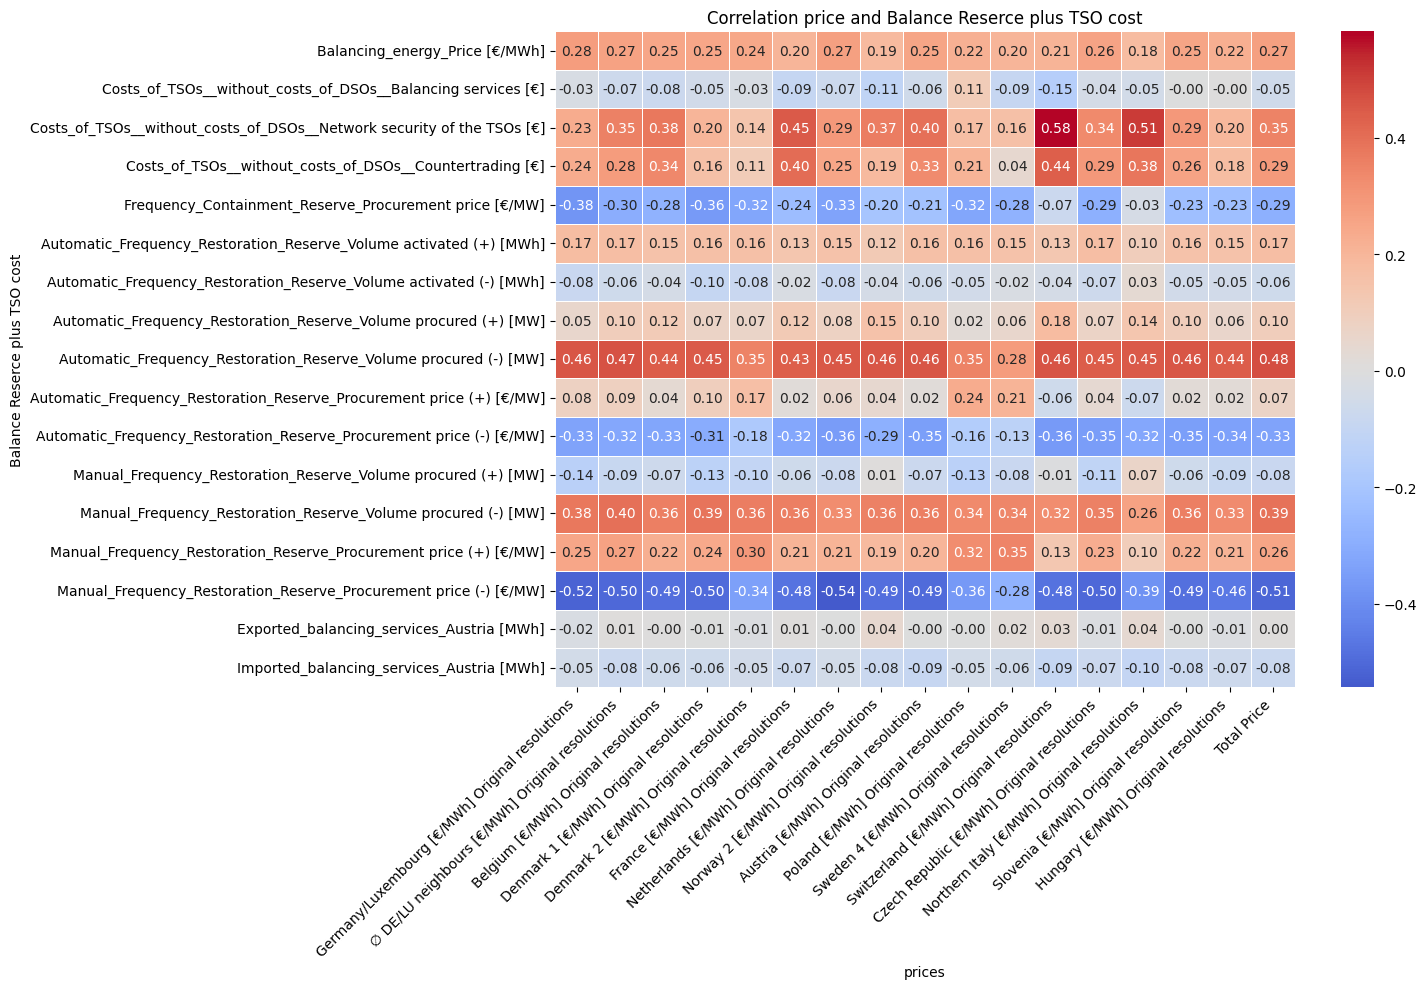

In [66]:
price_features = dic['prices'].columns.tolist()
price_features.remove('DE/AT/LU [€/MWh] Original resolutions')
other_features = ['Balancing_energy_Price [€/MWh]',
                  'Costs_of_TSOs__without_costs_of_DSOs__Balancing services [€]',
                  'Costs_of_TSOs__without_costs_of_DSOs__Network security of the TSOs [€]',
                  'Costs_of_TSOs__without_costs_of_DSOs__Countertrading [€]',
                  'Frequency_Containment_Reserve_Procurement price [€/MW]',
                  'Automatic_Frequency_Restoration_Reserve_Volume activated (+) [MWh]',
                  'Automatic_Frequency_Restoration_Reserve_Volume activated (-) [MWh]',
                  'Automatic_Frequency_Restoration_Reserve_Volume procured (+) [MW]',
                  'Automatic_Frequency_Restoration_Reserve_Volume procured (-) [MW]',
                  'Automatic_Frequency_Restoration_Reserve_Procurement price (+) [€/MW]',
                  'Automatic_Frequency_Restoration_Reserve_Procurement price (-) [€/MW]',
                  'Manual_Frequency_Restoration_Reserve_Volume procured (+) [MW]',
                  'Manual_Frequency_Restoration_Reserve_Volume procured (-) [MW]',
                  'Manual_Frequency_Restoration_Reserve_Procurement price (+) [€/MW]',
                  'Manual_Frequency_Restoration_Reserve_Procurement price (-) [€/MW]',
                  'Exported_balancing_services_Austria [MWh]',
                  'Imported_balancing_services_Austria [MWh]']

corr_matrix = dic['prices'][price_features].apply(
    lambda col: resampled_df[other_features].corrwith(col)
)
plt.figure(figsize=(15, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    linewidths=0.5
)
plt.title('Correlation price and Balance Reserce plus TSO cost')
plt.xlabel('prices')
plt.ylabel('Balance Reserce plus TSO cost')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

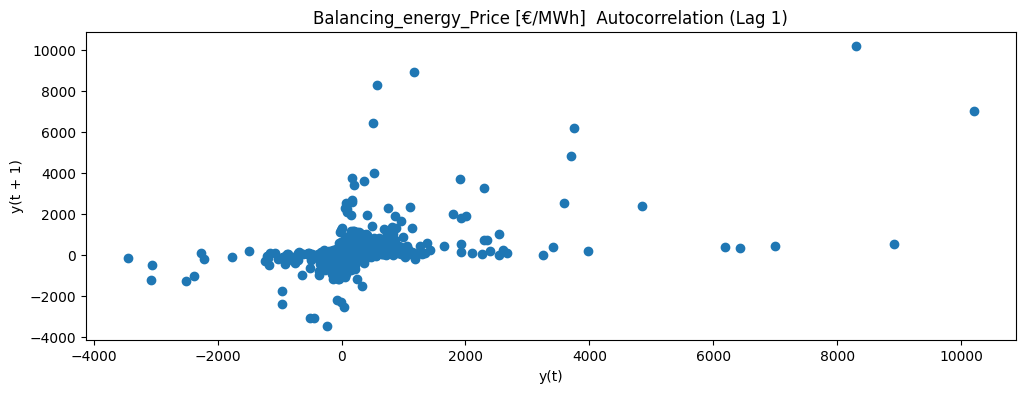

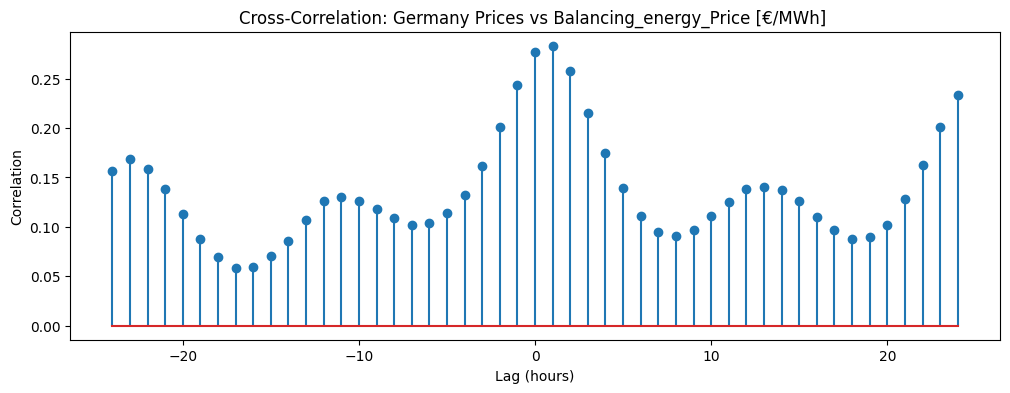

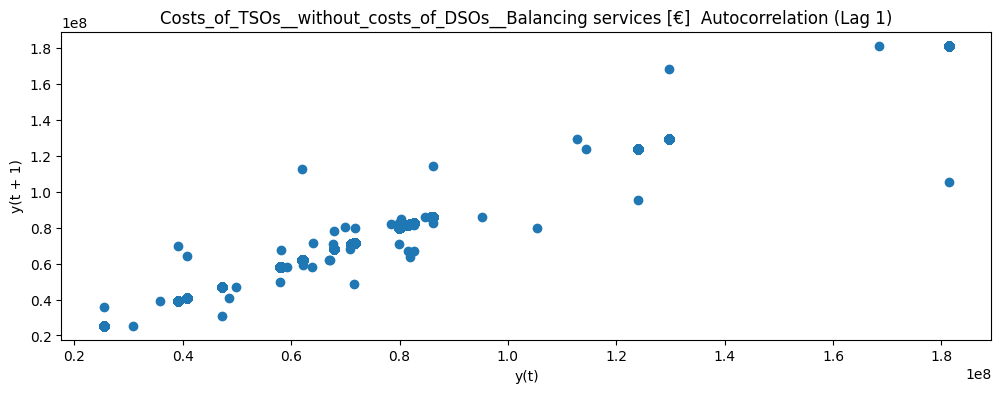

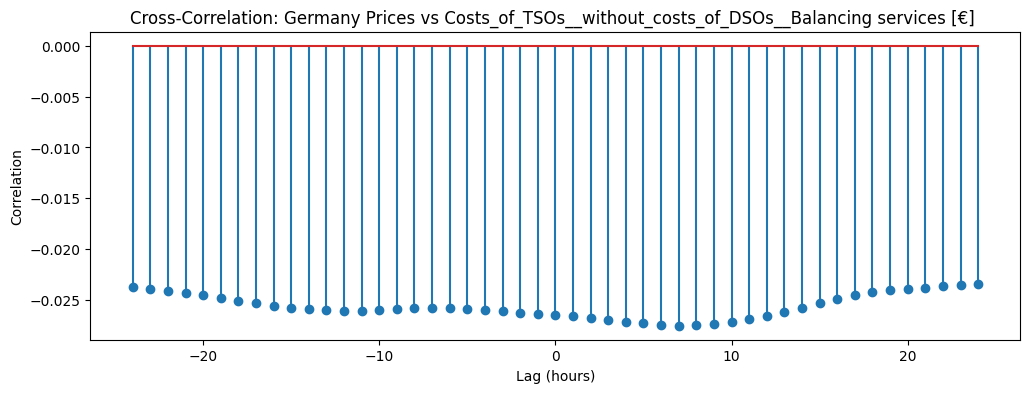

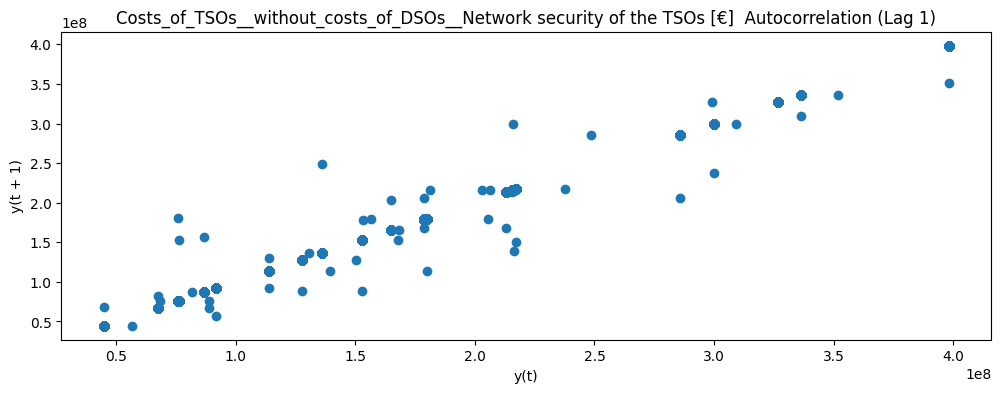

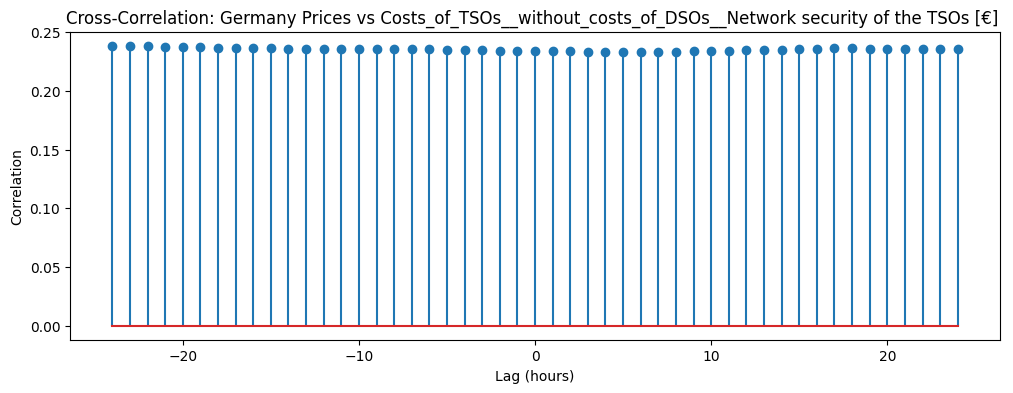

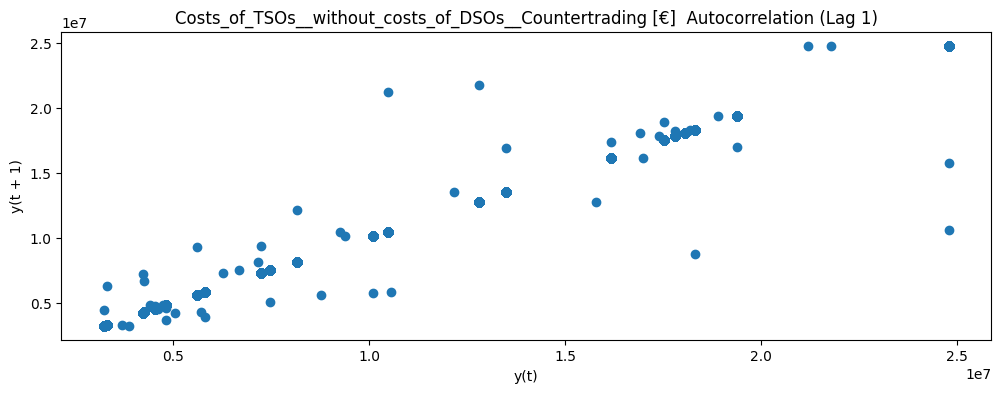

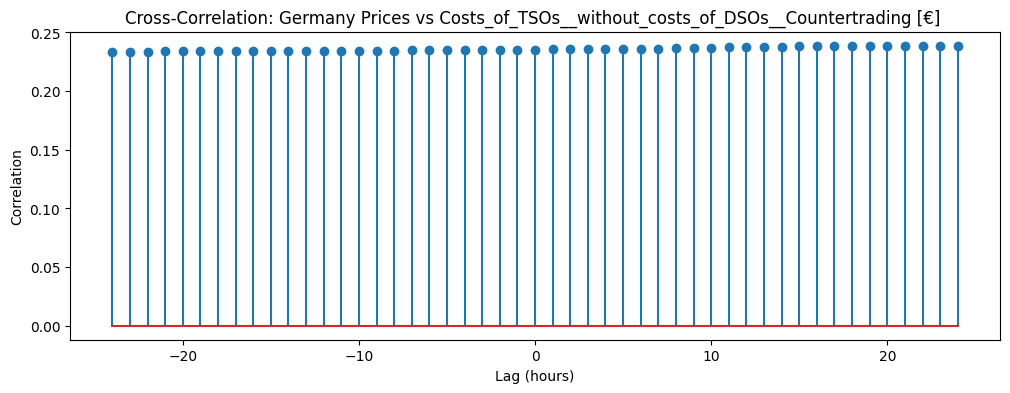

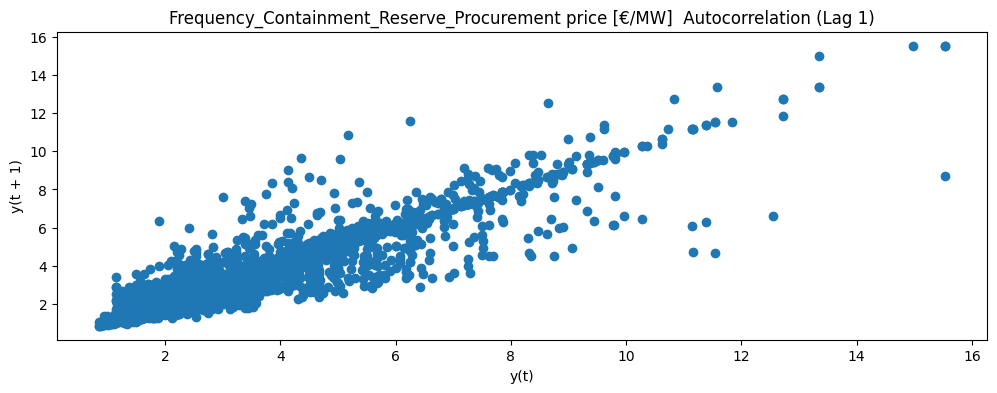

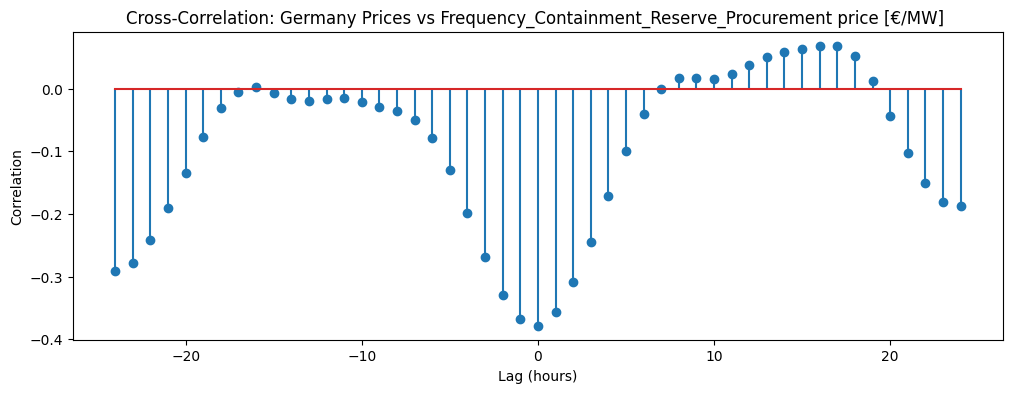

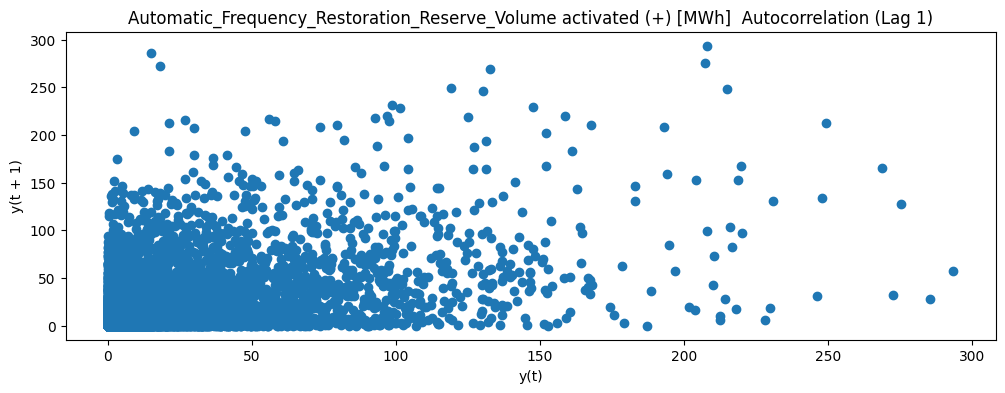

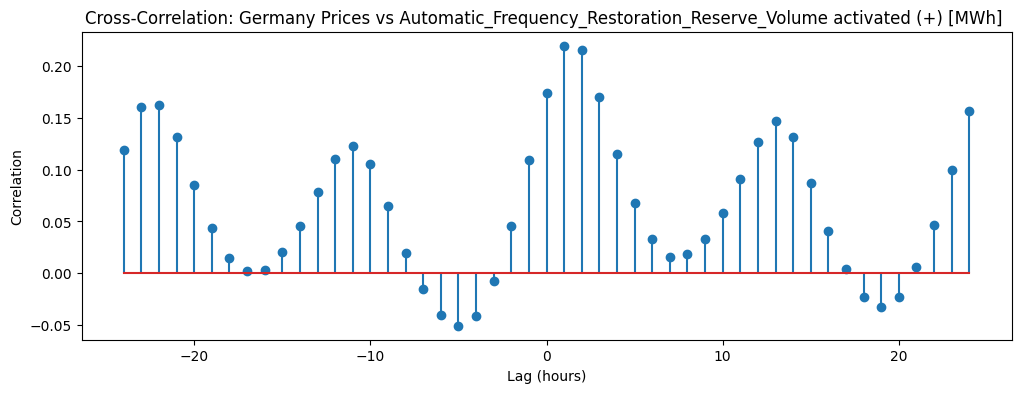

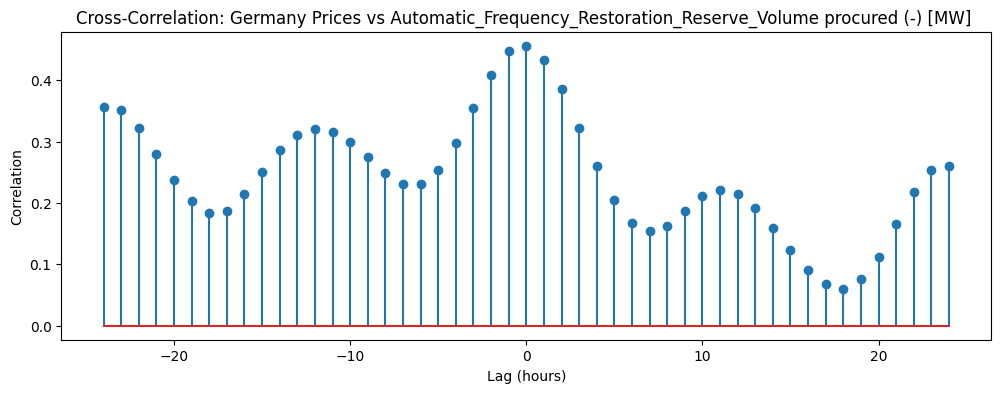

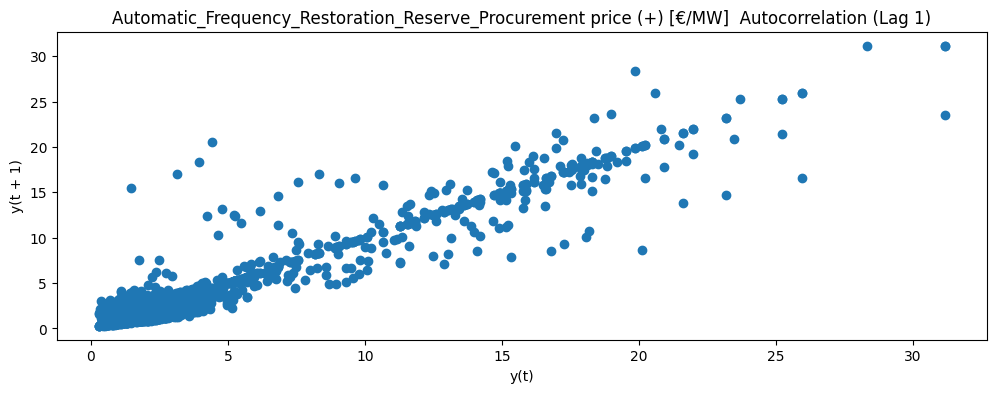

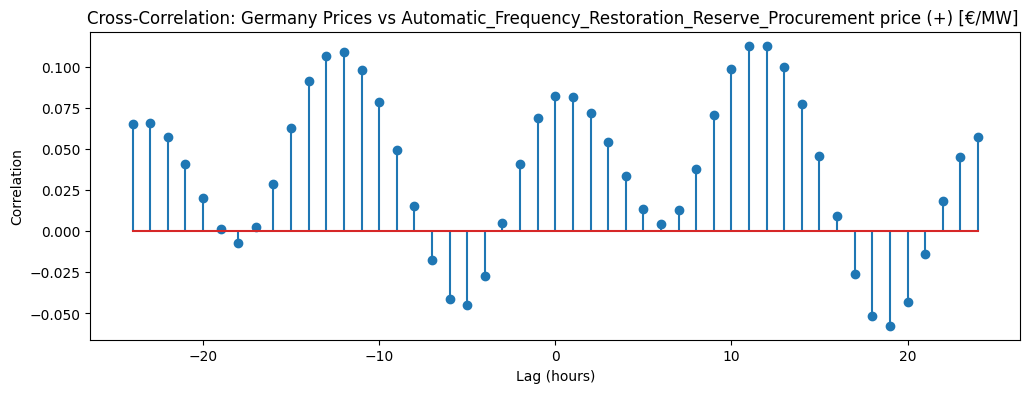

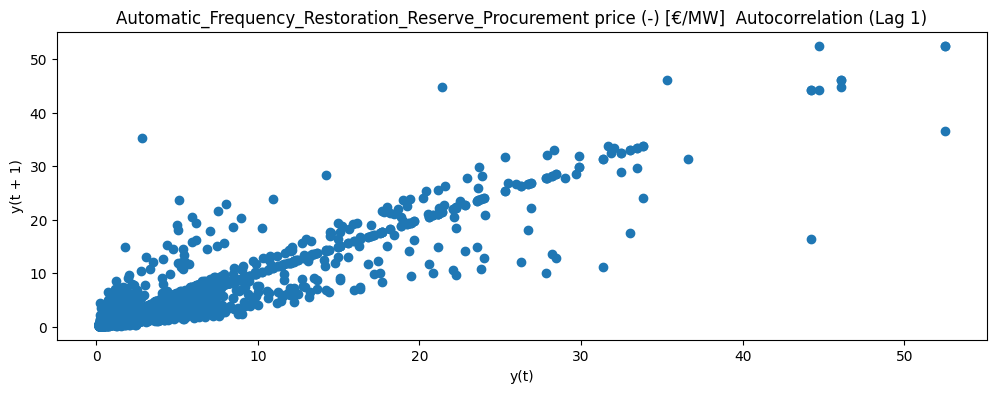

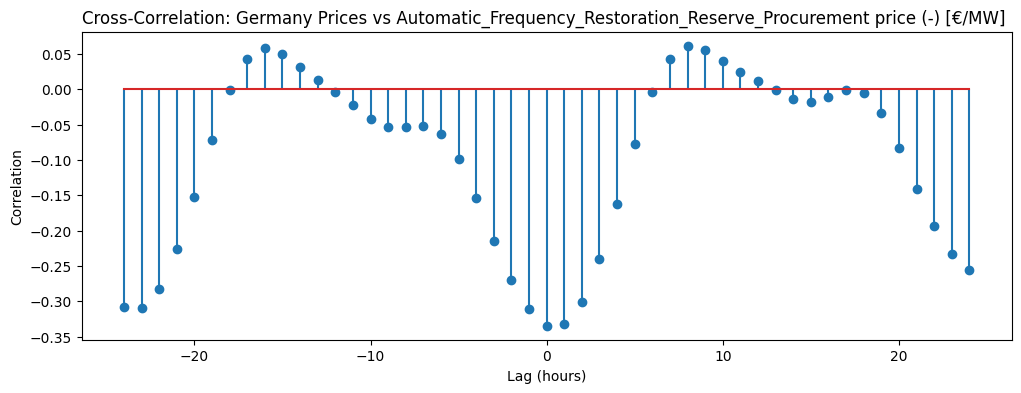

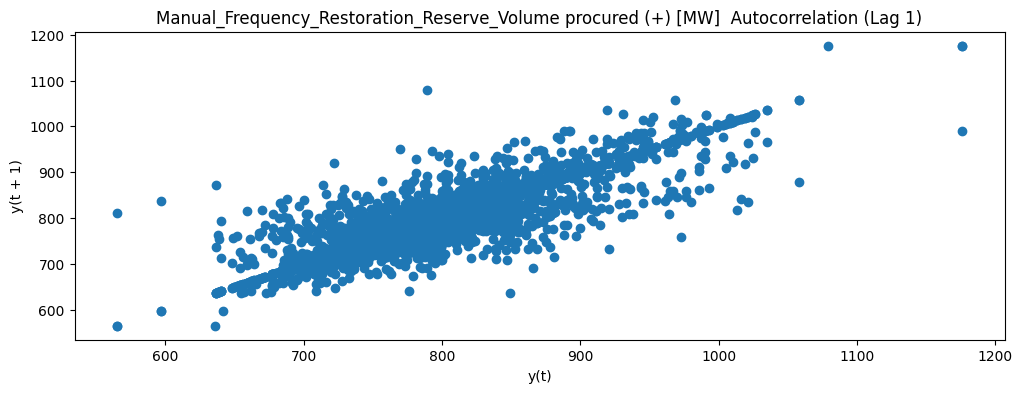

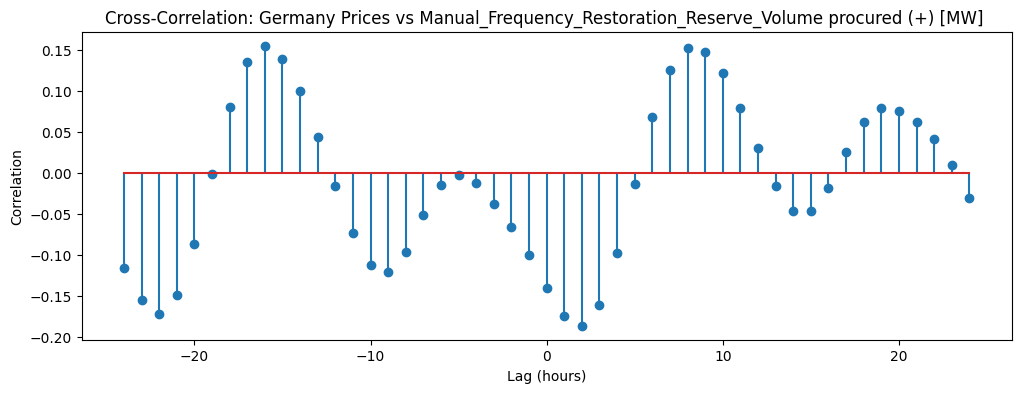

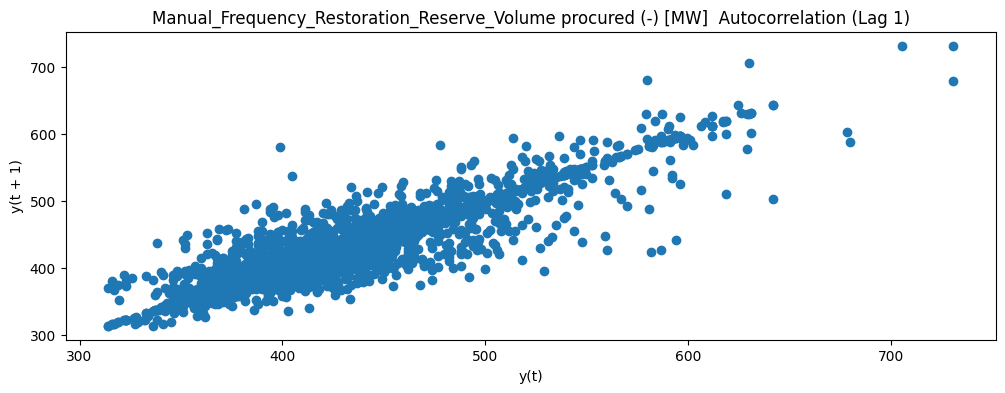

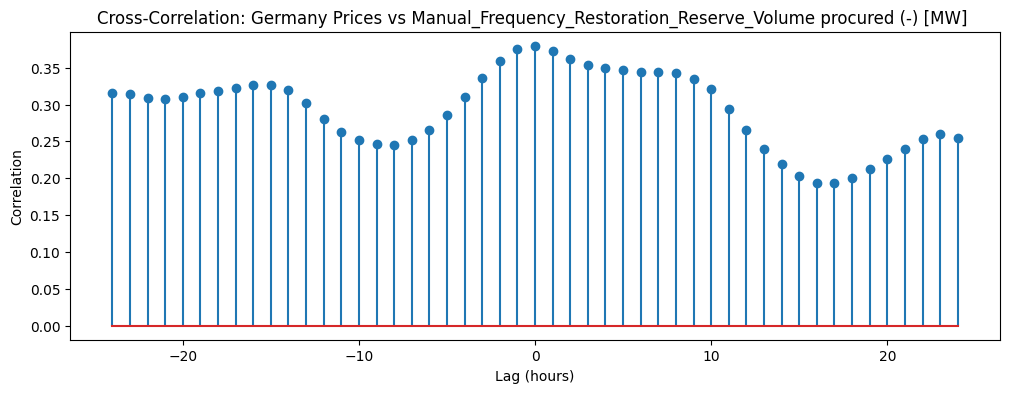

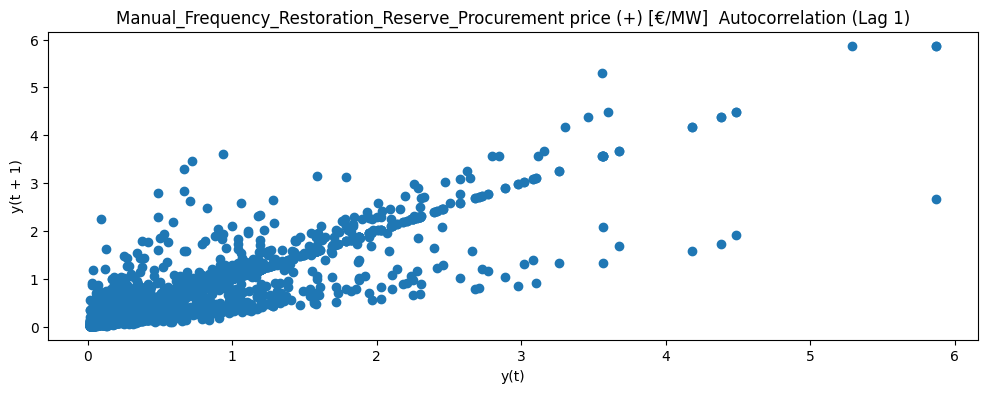

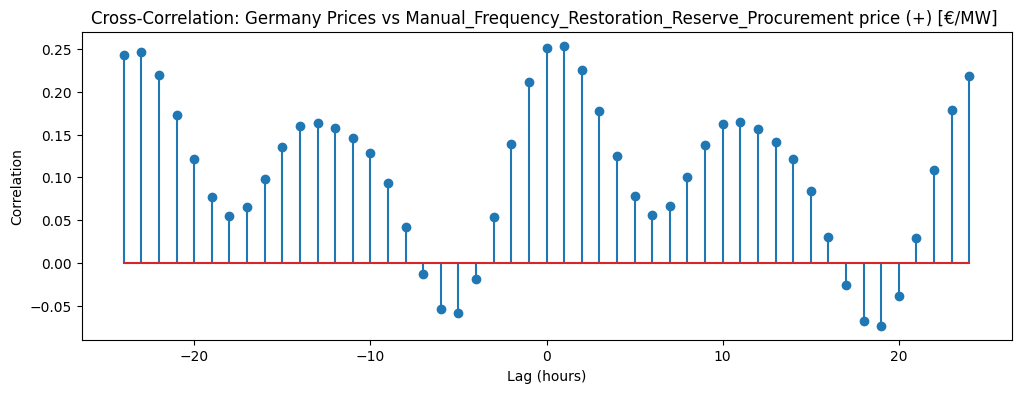

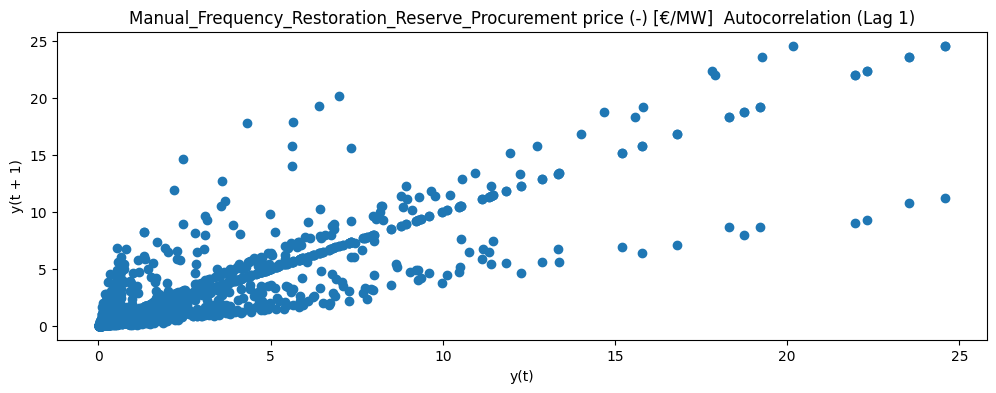

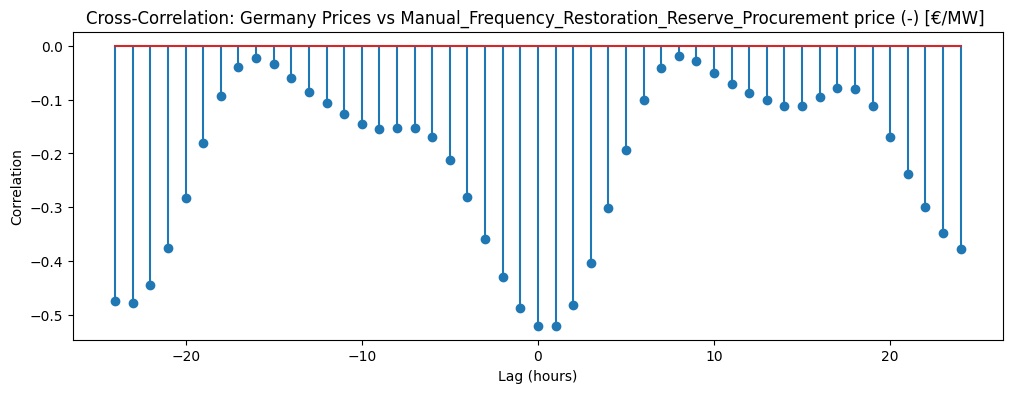

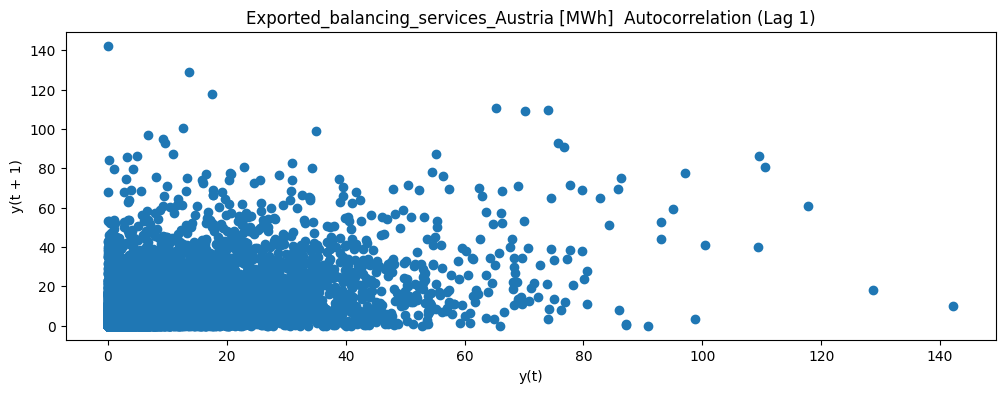

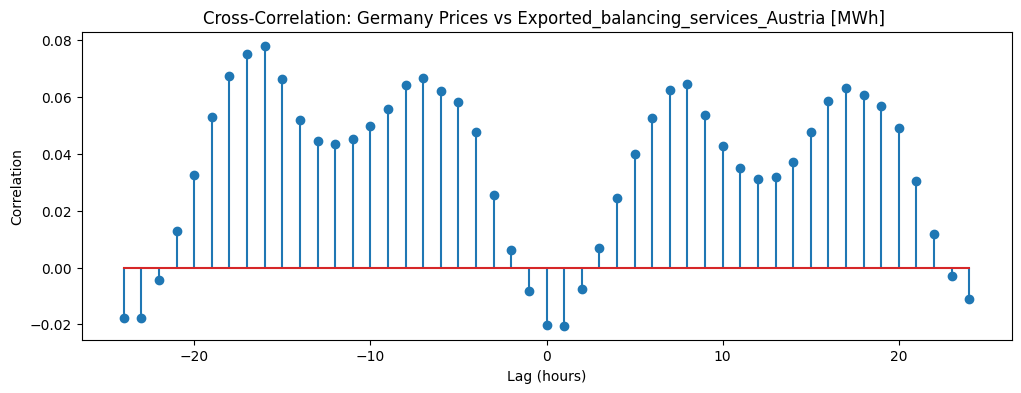

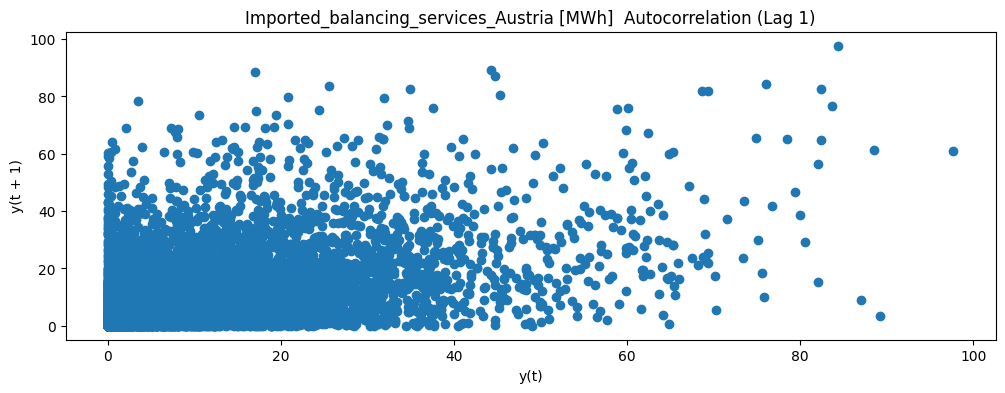

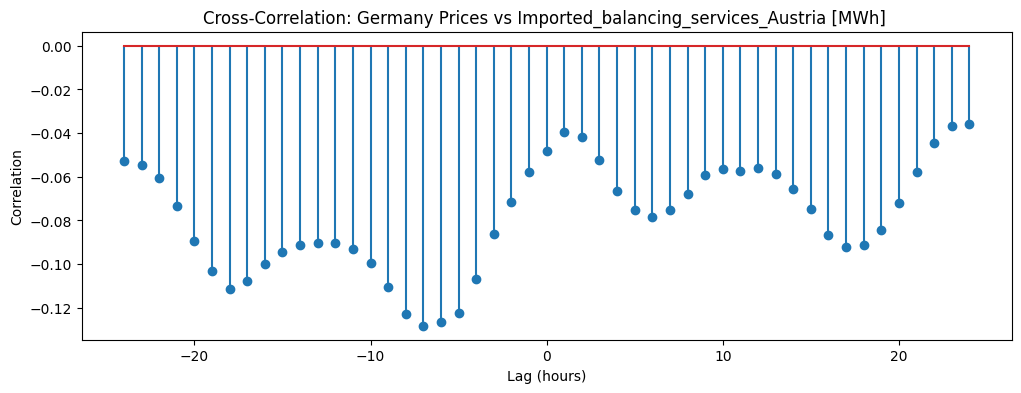

In [67]:
max_lag = 24  # 24 hours for daily pattern analysis

for col in other_features:
    fig, ax = plt.subplots(figsize=(12,4))
    pd.plotting.lag_plot(resampled_df[col], lag=1, ax=ax)
    ax.set_title(f'{col}  Autocorrelation (Lag 1)')
    plt.show()

    # Cross-correlation with prices
    ccf_values = [resampled_df[f'Day-ahead_prices_Germany/Luxembourg [€/MWh]'].corr(
        resampled_df[col].shift(lag))
        for lag in range(-max_lag, max_lag+1)]

    plt.figure(figsize=(12,4))
    plt.stem(range(-max_lag, max_lag+1), ccf_values)
    plt.title(f'Cross-Correlation: Germany Prices vs {col} ')
    plt.xlabel('Lag (hours)')
    plt.ylabel('Correlation')
    plt.show()
